## **Notes:**
#### Purpose: creates the figures for the temperature trends, model performance on temperature trends and the map from the method section visualizing the event and boxes over which analogues are selected and trends are averaged

# **Preparation**

In [1]:
import numpy as np # for storing vector and matrix data
import matplotlib.pyplot as plt # to plot figures
import netCDF4 as nc #to read netCDF files
import cartopy.crs as ccrs # to plot maps
# (ergens in test ook: import cartopy as cart)
import cartopy.feature as cf
import pickle
import os
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

In [2]:
def load_data(path,*variables_to_add):
  """
Provide the path to a file and the variables you want to extract
  """
  data = nc.Dataset(path, mode='r')
  variable_list = []
  for variable in variables_to_add:
    var =data.variables[variable][:]
    variable_list.append(var)
  return variable_list

In [3]:
def prep_streamfunction(data):
    """
    doen nadat bijgesneden
    """
    list_for_new_data = []
    for i in range(data.shape[0]):
        data_day = data[i,:,:]
        day_mean = np.mean(data_day)
        new_data = data_day - day_mean
        list_for_new_data.append(new_data)
    new_array = np.array(list_for_new_data)
    
    return new_array

In [4]:
def plot_variable_normal(lat, lon, variable,title):
    plt.figure(figsize = (10,10))
    ax = plt.axes(projection = ccrs.PlateCarree())
    plot = plt.contourf(lon, lat, variable, cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = 15) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    ax.set_title(title)
    plt.colorbar(plot, ax=ax, orientation = "horizontal", label = "degree Celsius/GWD", pad = 0.05)
    #plt.savefig(f"{folder}/{name}.png",dpi=300)
    plt.show()
    plt.close()

In [5]:
def extract_area(S, N, W, E, lat, lon, variable,event = False):
    """
    This function slices the data given the S, N, W, E bounds. Use event = True if there are only two dimensions (since then there is no time dimension), this means after using this
    function you need to use event[0] to get the data
    """
    # Change longitude data to go from -180 to 180
    for i in range(len(lon)):
        if lon[i] > 180:
          lon[i] = lon[i] - 360
        else:
          lon[i] = lon[i]

    # Calculate the index of the bounds
    sIndex = np.argmin(np.abs(lat - S))
    nIndex = np.argmin(np.abs(lat - N))
    wIndex = np.argmin(np.abs(lon - W))
    eIndex = np.argmin(np.abs(lon - E))

    if event:
        variable = np.expand_dims(variable, axis = 0)

    if wIndex > eIndex: # If the west index is higher than the east index, think of the right side of the world map as left boundary and vice versa
        latSlice = lat[sIndex: nIndex + 1]
        lonSlice = np.concatenate((lon[wIndex:], lon[:eIndex + 1]))
        variableSlice = np.concatenate((variable[:, sIndex: nIndex + 1, wIndex:], variable[:, sIndex: nIndex + 1, :eIndex + 1]), axis = 2)

    else:
        latSlice = lat[sIndex: nIndex + 1]
        lonSlice = lon[wIndex: eIndex + 1]
        variableSlice = variable[:, sIndex: nIndex + 1, wIndex: eIndex + 1]

    return latSlice, lonSlice, variableSlice

In [6]:
def significance_standard_deviation(mean_array,standard_deviation_array):
    mask = np.zeros((mean_array.shape[0],mean_array.shape[1]))
    for i in range(mean_array.shape[0]):
        for j in range(mean_array.shape[1]):
            mean_value = mean_array[i,j]
            absolute_mean = np.abs(mean_value)
            std_value = standard_deviation_array[i,j]
            threshold = std_value*2
            if absolute_mean > threshold:
                mask[i,j] = 0
            else:
                mask[i,j] = 1
    return mask

In [7]:
def significance_standard_deviation_test(mean_array,standard_deviation_array):
    mask = np.zeros((mean_array.shape[0],mean_array.shape[1]))
    for i in range(mean_array.shape[0]):
        for j in range(mean_array.shape[1]):
            mean_value = mean_array[i,j]
            absolute_mean = np.abs(mean_value)
            std_value = standard_deviation_array[i,j]
            threshold = std_value*2
            if absolute_mean > threshold:
                mask[i,j] = 1
            else:
                mask[i,j] = 0
    return mask

In [8]:
def plot_difference(lat, lon, variable,significance_mask,title = "test"):
    plt.figure(figsize = (10,10))
    ax = plt.axes(projection = ccrs.PlateCarree())
    plot = plt.contourf(lon, lat, variable, cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = 15) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
    ax.contourf( lon, lat,significance_mask, levels=[-2,0,2], hatches=[None, '////'], colors='none', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    ax.set_title(title)
    plt.colorbar(plot, ax=ax, orientation = "horizontal", label = "Pressure (Pa)", pad = 0.05)
    #plt.savefig(f"{folder}/{name}.png",dpi=300)
    plt.show()
    plt.close()

In [9]:
def plot_difference2(lat, lon, variable,significance_mask,title = "test"):
    plt.figure(figsize = (10,10))
    ax = plt.axes(projection = ccrs.PlateCarree())
    plot = plt.contourf(lon, lat, variable, cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = 15) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
    ax.contourf( lon, lat,significance_mask, levels=[-0.5,0.5,1.5], hatches=[ None,'////'], colors='none', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    ax.set_title(title)
    plt.colorbar(plot, ax=ax, orientation = "horizontal", label = "Pressure (Pa)", pad = 0.05)
    #plt.savefig(f"{folder}/{name}.png",dpi=300)
    plt.show()
    plt.close()

In [10]:
def plot_difference3(lat, lon, variable,significance_mask,title = "test"):
    plt.figure(figsize = (10,10))
    ax = plt.axes(projection = ccrs.PlateCarree())
    plot = plt.contourf(lon, lat, variable, cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = 15) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
    ax.contourf( lon, lat,significance_mask, levels=[0.5,1.5], hatches=['////'], colors='none', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    ax.set_title(title)
    plt.colorbar(plot, ax=ax, orientation = "horizontal", label = "Pressure (Pa)", pad = 0.05)
    #plt.savefig(f"{folder}/{name}.png",dpi=300)
    plt.show()
    plt.close()

In [11]:
def plot_difference4(lat, lon, variable,significance_mask,title = "test"):
    plt.figure(figsize = (10,10))
    ax = plt.axes(projection = ccrs.PlateCarree())
    plot = plt.contourf(lon, lat, variable, cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = 15) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
    ax.contourf( lon, lat,significance_mask, levels=[-2,0.5,2], hatches=[None,'////'], colors='none', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    ax.set_title(title)
    plt.colorbar(plot, ax=ax, orientation = "horizontal", label = "Pressure (Pa)", pad = 0.05)
    #plt.savefig(f"{folder}/{name}.png",dpi=300)
    plt.show()
    plt.close()

# **Plots**

## **Temperature trend era5 map prepped 2023**

In [56]:
#Select which region to plot
Sv = 32
Nv = 63
Wv = -13
Ev = 28

### Data

In [57]:
#Load data for total trend
os.chdir("C:/Users/douwe/Documents/Master thesis/publiceren/data_noest/total_trend")
total_Txx = np.load("MAM_era5_TXx_slope_regridded_data_until_2023.npy")
total_Txm = np.load("MAM_era5_TXm_slope_regridded_data_until_2023.npy")
total_lat = np.load("MAM_era5_lat_extracted_regridded_data_until_2023.npy")
total_lon = np.load("MAM_era5_lon_extracted_regridded_data_until_2023.npy")
total_Txx_se = np.load("MAM_era5_TXx_stderr_regridded_data_until_2023.npy")
total_Txm_se = np.load("MAM_era5_TXm_stderr_regridded_data_until_2023.npy")

#with open("MAM_era5_meanTxxlist_regridded_data_until_2023.pkl", 'rb') as file:  # Open in binary mode for pickled files
    #total_Txx_trend = pickle.load(file)
#with open("MAM_era5_meanTxmlist_regridded_data_until_2023.pkl", 'rb') as file:  # Open in binary mode for pickled files
    #total_Txm_trend = pickle.load(file)

In [58]:
#Load data for dynamical trend
os.chdir("C:/Users/douwe/Documents/Master thesis/publiceren/data_noest/era5_prepared_psi")
dynamical_Txx = np.load("MAM_era5_TXx_slope_regridded_data_until_2023.npy")
dynamical_Txm = np.load("MAM_era5_TXm_slope_regridded_data_until_2023.npy")
dynamical_lat = np.load("MAM_era5_lat_extracted_regridded_data_until_2023.npy")
dynamical_lon = np.load("MAM_era5_lon_extracted_regridded_data_until_2023.npy")
dynamical_Txx_se = np.load("MAM_era5_TXx_stderr_regridded_data_until_2023.npy")
dynamical_Txm_se = np.load("MAM_era5_TXm_stderr_regridded_data_until_2023.npy")

# with open("MAM_era5_meanTxxlist_regridded_data_until_2023.pkl", 'rb') as file:  # Open in binary mode for pickled files
#     dynamical_Txx_trend = pickle.load(file)
# with open("MAM_era5_meanTxmlist_regridded_data_until_2023.pkl", 'rb') as file:  # Open in binary mode for pickled files
#     dynamical_Txm_trend = pickle.load(file)

In [59]:
#Calculate masks
total_Txx_mask = significance_standard_deviation(total_Txx,total_Txx_se)
total_Txm_mask = significance_standard_deviation(total_Txm,total_Txm_se)
dynamical_Txx_mask = significance_standard_deviation(dynamical_Txx,dynamical_Txx_se)
dynamical_Txm_mask = significance_standard_deviation(dynamical_Txm,dynamical_Txm_se)

In [60]:
#Extract area for total
lat_total_box,lon_total_box,total_Txx_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txx,event = True)
_,_,total_Txm_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txm,event = True)
_,_,total_Txx_mask_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txx_mask,event = True)
_,_,total_Txm_mask_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txm_mask,event = True)

In [61]:
#Extract area for dynamical
lat_dynamical_box,lon_dynamical_box,dynamical_Txx_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txx,event = True)
_,_,dynamical_Txm_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txm,event = True)
_,_,dynamical_Txx_mask_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txx_mask,event = True)
_,_,dynamical_Txm_mask_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txm_mask,event = True)

In [62]:
#Squeeze everyting for total
total_Txx_b = np.squeeze(total_Txx_b)
total_Txm_b = np.squeeze(total_Txm_b)
total_Txx_mask_b = np.squeeze(total_Txx_mask_b)
total_Txm_mask_b = np.squeeze(total_Txm_mask_b)

In [63]:
#Squeeze everyting for dynamical
dynamical_Txx_b = np.squeeze(dynamical_Txx_b)
dynamical_Txm_b = np.squeeze(dynamical_Txm_b)
dynamical_Txx_mask_b = np.squeeze(dynamical_Txx_mask_b)
dynamical_Txm_mask_b = np.squeeze(dynamical_Txm_mask_b)

### Plot

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

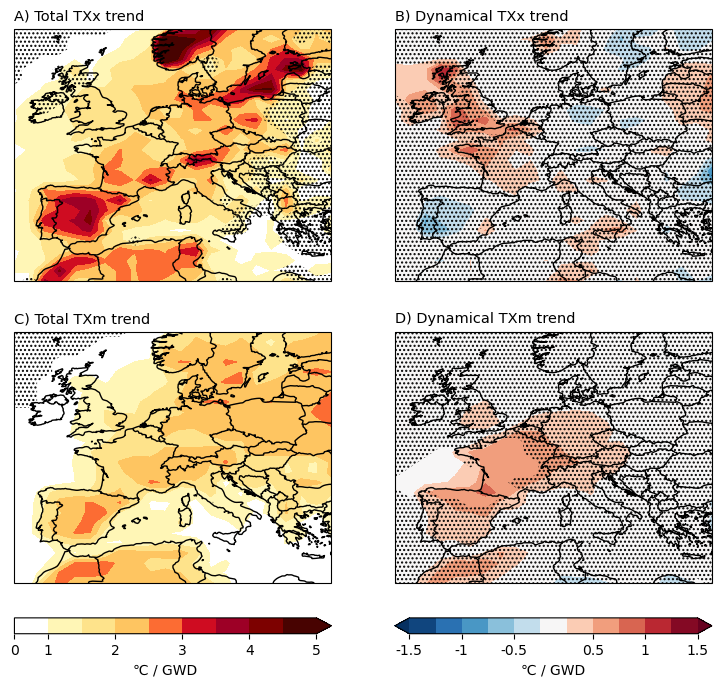

In [81]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 9), subplot_kw={'projection': ccrs.PlateCarree()})

#optie 1
levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4])
custom_colors1 = ["#ffffff","#ffffff","#fff6b6","#fee38b","#fec561","#fc6c33","#cf0c21","#9d0026"]
custom_cmap1 = mcolors.ListedColormap(custom_colors1)

levels2 = np.array([-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25])
custom_colors2 = ["#ffffff","#fee38b","#fec561","#fd9f44","#fc6c33","#ef3323","#cf0c21","#9d0026"]
custom_cmap2 = mcolors.ListedColormap(custom_colors2)
custom_cmap2 = "RdBu_r"


levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4,4.5,5])
#levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4,4.5,5,6])
#Vautard = ["#ffffff","#f2f3e4","#f4f4b6","#f4c460","#f38a37","#eb3923","#b80229","#7d0100","#480301"]
Vautard = ["#ffffff","#ffffff","#fff6b6","#fee38b","#fec561","#fc6c33","#cf0c21","#9d0026","#7d0100","#480301"]

custom_cmap1 = mcolors.ListedColormap(Vautard)
levels2 = np.array([-1.5,-1.25,-1,-0.75,-0.5,0.5,0.75,1,1.25,1.5])
levels2 = np.array([-1.5,-1.25,-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1,1.25,1.5])

custom_colors2 = ["#ffffff","#fee38b","#fec561","#fd9f44","#fc6c33","#ef3323","#cf0c21","#9d0026"]
#custom_cmap2 = mcolors.ListedColormap(hex_colors2)
custom_cmap2 = "RdBu_r"

#optie 2
# levels1 = np.linspace(0,4.5,16)
# custom_cmap1 = "YlOrRd"
# levels2 = np.array([0,0.3,0.6,0.9,1.2,1.5,1.8])
# levels2 = np.linspace(0,1.8,13)
# custom_cmap2 = "YlOrRd"

#ax1 = plt.axes(projection = ccrs.PlateCarree())
plot1 = ax1.contourf(lon_total_box, lat_total_box, total_Txx_b, cmap = custom_cmap1, transform = ccrs.PlateCarree(), levels = levels1,extend = "max") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax1.contourf(lon_total_box, lat_total_box,total_Txx_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.add_feature(cf.BORDERS)
ax1.set_title("A) Total TXx trend",loc="left",fontsize = 10.5)

#ax3
plot3 = ax3.contourf(lon_total_box, lat_total_box, total_Txm_b, cmap = custom_cmap1, transform = ccrs.PlateCarree(), levels = levels1,extend = "max") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax3.contourf(lon_total_box, lat_total_box,total_Txm_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.add_feature(cf.BORDERS)
ax3.set_title("C) Total TXm trend",loc="left",fontsize = 10.5)

#ax2
plot2 = ax2.contourf(lon_dynamical_box, lat_dynamical_box, dynamical_Txx_b, cmap = custom_cmap2, transform = ccrs.PlateCarree(), levels = levels2, extend = "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax2.contourf(lon_dynamical_box, lat_dynamical_box,dynamical_Txx_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.add_feature(cf.BORDERS)
ax2.set_title("B) Dynamical TXx trend",loc="left",fontsize = 10.5)


#ax4
plot4 = ax4.contourf(lon_dynamical_box, lat_dynamical_box, dynamical_Txm_b, cmap = custom_cmap2, transform = ccrs.PlateCarree(), levels = levels2, extend = "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax4.contourf(lon_dynamical_box, lat_dynamical_box,dynamical_Txm_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax4.coastlines()
ax4.add_feature(cf.BORDERS)
ax4.set_title("D) Dynamical TXm trend",loc="left",fontsize = 10.5)


cbar1 = plt.colorbar(plot1, ax=[ax1,ax3], orientation = "horizontal", label = "\N{DEGREE CELSIUS} / GWD", pad = 0.05)
cbar2 = plt.colorbar(plot4, ax=[ax2,ax4], orientation = "horizontal", label = "\N{DEGREE CELSIUS} / GWD", pad = 0.05)

cbar2.set_ticks([-1.5,-1,-0.5,0.5,1,1.5])
cbar2.set_ticklabels([-1.5,-1,-0.5,0.5,1,1.5])
cbar1.set_ticks([0,1,2,3,4,5])
cbar1.set_ticklabels([0,1,2,3,4,5])
#plt.subplots_adjust(wspace = 0.1)
plt.tight_layout # als layout() choked het alles
#plt.savefig("/usr/people/noest/stage_folders/outputs/figures_net/temperaturetrendprepped2023_sig2_labelC_cmap2.png",dpi=600)


### Test

## **Combined**

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

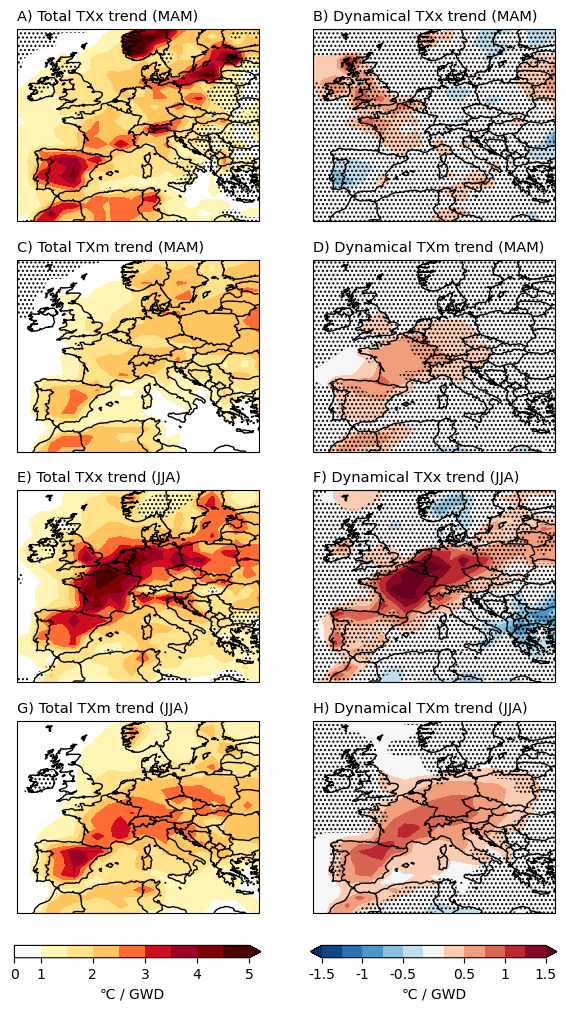

In [12]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2, figsize=(7, 14), subplot_kw={'projection': ccrs.PlateCarree()}) #eerste save is size 7,14

#MAM
#Select which region to plot
Sv = 32
Nv = 63
Wv = -13
Ev = 28
#Load data for total trend
os.chdir("C:/Users/douwe/Documents/Master thesis/publiceren/data_noest/total_trend")
total_Txx = np.load("MAM_era5_TXx_slope_regridded_data_until_2023.npy")
total_Txm = np.load("MAM_era5_TXm_slope_regridded_data_until_2023.npy")
total_lat = np.load("MAM_era5_lat_extracted_regridded_data_until_2023.npy")
total_lon = np.load("MAM_era5_lon_extracted_regridded_data_until_2023.npy")
total_Txx_se = np.load("MAM_era5_TXx_stderr_regridded_data_until_2023.npy")
total_Txm_se = np.load("MAM_era5_TXm_stderr_regridded_data_until_2023.npy")
os.chdir("C:/Users/douwe/Documents/Master thesis/publiceren/data_noest/era5_prepared_psi")
dynamical_Txx = np.load("MAM_era5_TXx_slope_regridded_data_until_2023.npy")
dynamical_Txm = np.load("MAM_era5_TXm_slope_regridded_data_until_2023.npy")
dynamical_lat = np.load("MAM_era5_lat_extracted_regridded_data_until_2023.npy")
dynamical_lon = np.load("MAM_era5_lon_extracted_regridded_data_until_2023.npy")
dynamical_Txx_se = np.load("MAM_era5_TXx_stderr_regridded_data_until_2023.npy")
dynamical_Txm_se = np.load("MAM_era5_TXm_stderr_regridded_data_until_2023.npy")
#Calculate masks
total_Txx_mask = significance_standard_deviation(total_Txx,total_Txx_se)
total_Txm_mask = significance_standard_deviation(total_Txm,total_Txm_se)
dynamical_Txx_mask = significance_standard_deviation(dynamical_Txx,dynamical_Txx_se)
dynamical_Txm_mask = significance_standard_deviation(dynamical_Txm,dynamical_Txm_se)
#Extract area for total
lat_total_box,lon_total_box,total_Txx_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txx,event = True)
_,_,total_Txm_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txm,event = True)
_,_,total_Txx_mask_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txx_mask,event = True)
_,_,total_Txm_mask_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txm_mask,event = True)
#Extract area for dynamical
lat_dynamical_box,lon_dynamical_box,dynamical_Txx_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txx,event = True)
_,_,dynamical_Txm_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txm,event = True)
_,_,dynamical_Txx_mask_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txx_mask,event = True)
_,_,dynamical_Txm_mask_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txm_mask,event = True)
#Squeeze everyting for total
total_Txx_b = np.squeeze(total_Txx_b)
total_Txm_b = np.squeeze(total_Txm_b)
total_Txx_mask_b = np.squeeze(total_Txx_mask_b)
total_Txm_mask_b = np.squeeze(total_Txm_mask_b)
#Squeeze everyting for dynamical
dynamical_Txx_b = np.squeeze(dynamical_Txx_b)
dynamical_Txm_b = np.squeeze(dynamical_Txm_b)
dynamical_Txx_mask_b = np.squeeze(dynamical_Txx_mask_b)
dynamical_Txm_mask_b = np.squeeze(dynamical_Txm_mask_b)

#optie 1
levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4])
custom_colors1 = ["#ffffff","#ffffff","#fff6b6","#fee38b","#fec561","#fc6c33","#cf0c21","#9d0026"]
custom_cmap1 = mcolors.ListedColormap(custom_colors1)

levels2 = np.array([-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25])
custom_colors2 = ["#ffffff","#fee38b","#fec561","#fd9f44","#fc6c33","#ef3323","#cf0c21","#9d0026"]
custom_cmap2 = mcolors.ListedColormap(custom_colors2)
custom_cmap2 = "RdBu_r"


levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4,4.5,5])
#levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4,4.5,5,6])
#Vautard = ["#ffffff","#f2f3e4","#f4f4b6","#f4c460","#f38a37","#eb3923","#b80229","#7d0100","#480301"]
Vautard = ["#ffffff","#ffffff","#fff6b6","#fee38b","#fec561","#fc6c33","#cf0c21","#9d0026","#7d0100","#480301"]

custom_cmap1 = mcolors.ListedColormap(Vautard)
levels2 = np.array([-1.5,-1.25,-1,-0.75,-0.5,0.5,0.75,1,1.25,1.5])
levels2 = np.array([-1.5,-1.25,-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1,1.25,1.5])

custom_colors2 = ["#ffffff","#fee38b","#fec561","#fd9f44","#fc6c33","#ef3323","#cf0c21","#9d0026"]
#custom_cmap2 = mcolors.ListedColormap(hex_colors2)
custom_cmap2 = "RdBu_r"

#optie 2
# levels1 = np.linspace(0,4.5,16)
# custom_cmap1 = "YlOrRd"
# levels2 = np.array([0,0.3,0.6,0.9,1.2,1.5,1.8])
# levels2 = np.linspace(0,1.8,13)
# custom_cmap2 = "YlOrRd"

#ax1 = plt.axes(projection = ccrs.PlateCarree())
plot1 = ax1.contourf(lon_total_box, lat_total_box, total_Txx_b, cmap = custom_cmap1, transform = ccrs.PlateCarree(), levels = levels1,extend = "max") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax1.contourf(lon_total_box, lat_total_box,total_Txx_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.add_feature(cf.BORDERS)
ax1.set_title("A) Total TXx trend (MAM)",loc="left",fontsize = 10.5)

#ax3
plot3 = ax3.contourf(lon_total_box, lat_total_box, total_Txm_b, cmap = custom_cmap1, transform = ccrs.PlateCarree(), levels = levels1,extend = "max") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax3.contourf(lon_total_box, lat_total_box,total_Txm_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.add_feature(cf.BORDERS)
ax3.set_title("C) Total TXm trend (MAM)",loc="left",fontsize = 10.5)

#ax2
plot2 = ax2.contourf(lon_dynamical_box, lat_dynamical_box, dynamical_Txx_b, cmap = custom_cmap2, transform = ccrs.PlateCarree(), levels = levels2, extend = "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax2.contourf(lon_dynamical_box, lat_dynamical_box,dynamical_Txx_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.add_feature(cf.BORDERS)
ax2.set_title("B) Dynamical TXx trend (MAM)",loc="left",fontsize = 10.5)


#ax4
plot4 = ax4.contourf(lon_dynamical_box, lat_dynamical_box, dynamical_Txm_b, cmap = custom_cmap2, transform = ccrs.PlateCarree(), levels = levels2, extend = "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax4.contourf(lon_dynamical_box, lat_dynamical_box,dynamical_Txm_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax4.coastlines()
ax4.add_feature(cf.BORDERS)
ax4.set_title("D) Dynamical TXm trend (MAM)",loc="left",fontsize = 10.5)


# cbar1 = plt.colorbar(plot1, ax=[ax1,ax3], orientation = "horizontal", label = "\N{DEGREE CELSIUS} / GWD", pad = 0.05)
# cbar2 = plt.colorbar(plot4, ax=[ax2,ax4], orientation = "horizontal", label = "\N{DEGREE CELSIUS} / GWD", pad = 0.05)

# cbar2.set_ticks([-1.5,-1,-0.5,0.5,1,1.5])
# cbar2.set_ticklabels([-1.5,-1,-0.5,0.5,1,1.5])
# cbar1.set_ticks([0,1,2,3,4,5])
# cbar1.set_ticklabels([0,1,2,3,4,5])
#plt.subplots_adjust(wspace = 0.1)
#plt.tight_layout # als layout() choked het alles
#plt.savefig("/usr/people/noest/stage_folders/outputs/figures_net/temperaturetrendprepped2023_sig2_labelC_cmap2.png",dpi=600)

#JJA
## **Temperature trend era5 map prepped 2023 JJA**
#Select which region to plot
Sv = 32
Nv = 63
Wv = -13
Ev = 28
#Load data for total trend
os.chdir("C:/Users/douwe/Documents/Master thesis/publiceren/data_noest/total_trend")
total_Txx = np.load("JJA_new_era5_TXx_slope_regridded_data_until_2023.npy")
total_Txm = np.load("JJA_new_era5_TXm_slope_regridded_data_until_2023.npy")
total_lat = np.load("JJA_new_era5_lat_extracted_regridded_data_until_2023.npy")
total_lon = np.load("JJA_new_era5_lon_extracted_regridded_data_until_2023.npy")
total_Txx_se = np.load("JJA_new_era5_TXx_stderr_regridded_data_until_2023.npy")
total_Txm_se = np.load("JJA_new_era5_TXm_stderr_regridded_data_until_2023.npy")

# with open("JJA_new_era5_meanTxxlist_regridded_data_until_2023.pkl", 'rb') as file:  # Open in binary mode for pickled files
#     total_Txx_trend = pickle.load(file)
# with open("JJA_new_era5_meanTxmlist_regridded_data_until_2023.pkl", 'rb') as file:  # Open in binary mode for pickled files
#     total_Txm_trend = pickle.load(file)
#Load data for dynamical trend
os.chdir("C:/Users/douwe/Documents/Master thesis/publiceren/data_noest/era5_prepared_psi")
dynamical_Txx = np.load("JJA_new_era5_TXx_slope_regridded_data_until_2023.npy")
dynamical_Txm = np.load("JJA_new_era5_TXm_slope_regridded_data_until_2023.npy")
dynamical_lat = np.load("JJA_new_era5_lat_extracted_regridded_data_until_2023.npy")
dynamical_lon = np.load("JJA_new_era5_lon_extracted_regridded_data_until_2023.npy")
dynamical_Txx_se = np.load("JJA_new_era5_TXx_stderr_regridded_data_until_2023.npy")
dynamical_Txm_se = np.load("JJA_new_era5_TXm_stderr_regridded_data_until_2023.npy")

# with open("JJA_new_era5_meanTxxlist_regridded_data_until_2023.pkl", 'rb') as file:  # Open in binary mode for pickled files
#     dynamical_Txx_trend = pickle.load(file)
# with open("JJA_new_era5_meanTxmlist_regridded_data_until_2023.pkl", 'rb') as file:  # Open in binary mode for pickled files
#     dynamical_Txm_trend = pickle.load(file)
#Calculate masks
total_Txx_mask = significance_standard_deviation(total_Txx,total_Txx_se)
total_Txm_mask = significance_standard_deviation(total_Txm,total_Txm_se)
dynamical_Txx_mask = significance_standard_deviation(dynamical_Txx,dynamical_Txx_se)
dynamical_Txm_mask = significance_standard_deviation(dynamical_Txm,dynamical_Txm_se)
#Extract area for total
lat_total_box,lon_total_box,total_Txx_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txx,event = True)
_,_,total_Txm_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txm,event = True)
_,_,total_Txx_mask_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txx_mask,event = True)
_,_,total_Txm_mask_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txm_mask,event = True)
#Extract area for dynamical
lat_dynamical_box,lon_dynamical_box,dynamical_Txx_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txx,event = True)
_,_,dynamical_Txm_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txm,event = True)
_,_,dynamical_Txx_mask_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txx_mask,event = True)
_,_,dynamical_Txm_mask_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txm_mask,event = True)
#Squeeze everyting for total
total_Txx_b = np.squeeze(total_Txx_b)
total_Txm_b = np.squeeze(total_Txm_b)
total_Txx_mask_b = np.squeeze(total_Txx_mask_b)
total_Txm_mask_b = np.squeeze(total_Txm_mask_b)
#Squeeze everyting for dynamical
dynamical_Txx_b = np.squeeze(dynamical_Txx_b)
dynamical_Txm_b = np.squeeze(dynamical_Txm_b)
dynamical_Txx_mask_b = np.squeeze(dynamical_Txx_mask_b)
dynamical_Txm_mask_b = np.squeeze(dynamical_Txm_mask_b)
### Plot

#optie 1
levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4])
custom_colors1 = ["#ffffff","#ffffff","#fff6b6","#fee38b","#fec561","#fc6c33","#cf0c21","#9d0026"]
custom_cmap1 = mcolors.ListedColormap(custom_colors1)

#levels2 = np.array([-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25])
custom_colors2 = ["#ffffff","#fee38b","#fec561","#fd9f44","#fc6c33","#ef3323","#cf0c21","#9d0026"]
custom_cmap2 = mcolors.ListedColormap(custom_colors2)
custom_cmap2 = "RdBu_r"


levels2 = np.array([-1.5,-1.25,-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1,1.25,1.5])
custom_colors2 = ["#ffffff","#fee38b","#fec561","#fd9f44","#fc6c33","#ef3323","#cf0c21","#9d0026"]
#custom_cmap2 = mcolors.ListedColormap(hex_colors2)
custom_cmap2 = "RdBu_r"

#optie 2
# levels1 = np.linspace(0,4.5,16)
# custom_cmap1 = "YlOrRd"
# levels2 = np.array([0,0.3,0.6,0.9,1.2,1.5,1.8])
# levels2 = np.linspace(0,1.8,13)
# custom_cmap2 = "YlOrRd"
levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4,4.5,5])
#levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4,4.5,5,6])
#Vautard = ["#ffffff","#f2f3e4","#f4f4b6","#f4c460","#f38a37","#eb3923","#b80229","#7d0100","#480301"]
Vautard = ["#ffffff","#ffffff","#fff6b6","#fee38b","#fec561","#fc6c33","#cf0c21","#9d0026","#7d0100","#480301"]

custom_cmap1 = mcolors.ListedColormap(Vautard)

#ax1 = plt.axes(projection = ccrs.PlateCarree())
plot1 = ax5.contourf(lon_total_box, lat_total_box, total_Txx_b, cmap = custom_cmap1, transform = ccrs.PlateCarree(), levels = levels1,extend = "max") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax5.contourf(lon_total_box, lat_total_box,total_Txx_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax5.coastlines()
ax5.add_feature(cf.BORDERS)
ax5.set_title("E) Total TXx trend (JJA)",loc="left",fontsize = 10.5)

#ax3
plot7 = ax7.contourf(lon_total_box, lat_total_box, total_Txm_b, cmap = custom_cmap1, transform = ccrs.PlateCarree(), levels = levels1,extend = "max") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax7.contourf(lon_total_box, lat_total_box,total_Txm_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax7.coastlines()
ax7.add_feature(cf.BORDERS)
ax7.set_title("G) Total TXm trend (JJA)",loc="left",fontsize = 10.5)

#ax2
plot2 = ax6.contourf(lon_dynamical_box, lat_dynamical_box, dynamical_Txx_b, cmap = custom_cmap2, transform = ccrs.PlateCarree(), levels = levels2, extend= "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax6.contourf(lon_dynamical_box, lat_dynamical_box,dynamical_Txx_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax6.coastlines()
ax6.add_feature(cf.BORDERS)
ax6.set_title("F) Dynamical TXx trend (JJA)",loc="left",fontsize = 10.5)


#ax4
plot8 = ax8.contourf(lon_dynamical_box, lat_dynamical_box, dynamical_Txm_b, cmap = custom_cmap2, transform = ccrs.PlateCarree(), levels = levels2, extend= "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax8.contourf(lon_dynamical_box, lat_dynamical_box,dynamical_Txm_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax8.coastlines()
ax8.add_feature(cf.BORDERS)
ax8.set_title("H) Dynamical TXm trend (JJA)",loc="left",fontsize = 10.5)


cbar1 = plt.colorbar(plot7, ax=[ax1,ax3,ax5,ax7], orientation = "horizontal", label = "\N{DEGREE CELSIUS} / GWD", pad = 0.03)
cbar2 = plt.colorbar(plot8, ax=[ax2,ax4,ax6,ax8], orientation = "horizontal", label = "\N{DEGREE CELSIUS} / GWD", pad = 0.03)

cbar2.set_ticks([-1.5,-1,-0.5,0.5,1,1.5])
cbar2.set_ticklabels([-1.5,-1,-0.5,0.5,1,1.5])
cbar1.set_ticks([0,1,2,3,4,5])
cbar1.set_ticklabels([0,1,2,3,4,5])
#plt.subplots_adjust(wspace = 0.1)

plt.tight_layout # als layout() choked het alles
#plt.savefig("C:/Users/douwe/Documents/Master thesis/publiceren/new_frequency_plot/temperature_combined.png",dpi=600)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

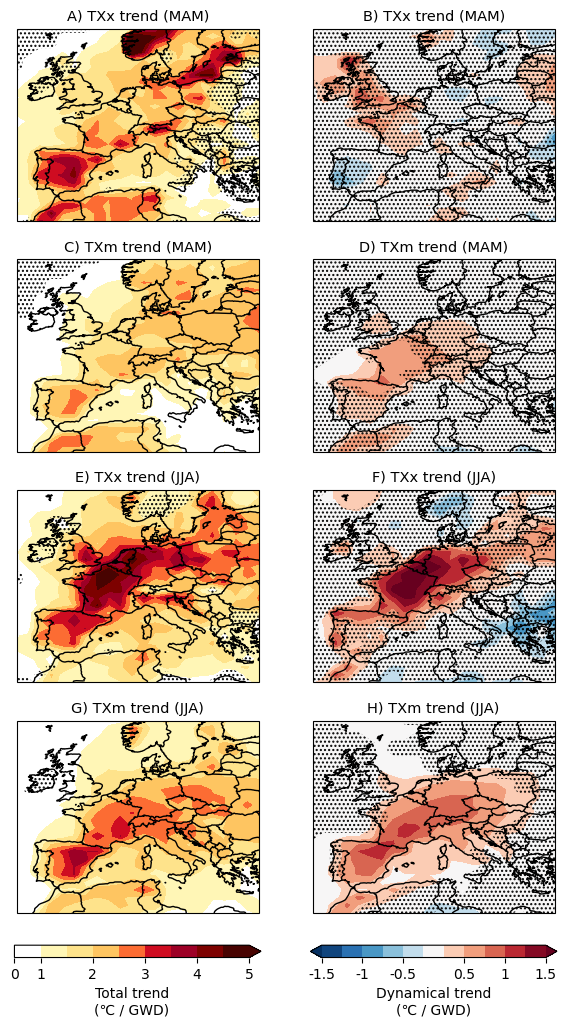

In [46]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2, figsize=(7, 14), subplot_kw={'projection': ccrs.PlateCarree()}) #eerste save is size 7,14

#MAM
#Select which region to plot
Sv = 32
Nv = 63
Wv = -13
Ev = 28
#Load data for total trend
os.chdir("C:/Users/douwe/Documents/Master thesis/publiceren/data_noest/total_trend")
total_Txx = np.load("MAM_era5_TXx_slope_regridded_data_until_2023.npy")
total_Txm = np.load("MAM_era5_TXm_slope_regridded_data_until_2023.npy")
total_lat = np.load("MAM_era5_lat_extracted_regridded_data_until_2023.npy")
total_lon = np.load("MAM_era5_lon_extracted_regridded_data_until_2023.npy")
total_Txx_se = np.load("MAM_era5_TXx_stderr_regridded_data_until_2023.npy")
total_Txm_se = np.load("MAM_era5_TXm_stderr_regridded_data_until_2023.npy")
os.chdir("C:/Users/douwe/Documents/Master thesis/publiceren/data_noest/era5_prepared_psi")
dynamical_Txx = np.load("MAM_era5_TXx_slope_regridded_data_until_2023.npy")
dynamical_Txm = np.load("MAM_era5_TXm_slope_regridded_data_until_2023.npy")
dynamical_lat = np.load("MAM_era5_lat_extracted_regridded_data_until_2023.npy")
dynamical_lon = np.load("MAM_era5_lon_extracted_regridded_data_until_2023.npy")
dynamical_Txx_se = np.load("MAM_era5_TXx_stderr_regridded_data_until_2023.npy")
dynamical_Txm_se = np.load("MAM_era5_TXm_stderr_regridded_data_until_2023.npy")
#Calculate masks
total_Txx_mask = significance_standard_deviation(total_Txx,total_Txx_se)
total_Txm_mask = significance_standard_deviation(total_Txm,total_Txm_se)
dynamical_Txx_mask = significance_standard_deviation(dynamical_Txx,dynamical_Txx_se)
dynamical_Txm_mask = significance_standard_deviation(dynamical_Txm,dynamical_Txm_se)
#Extract area for total
lat_total_box,lon_total_box,total_Txx_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txx,event = True)
_,_,total_Txm_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txm,event = True)
_,_,total_Txx_mask_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txx_mask,event = True)
_,_,total_Txm_mask_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txm_mask,event = True)
#Extract area for dynamical
lat_dynamical_box,lon_dynamical_box,dynamical_Txx_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txx,event = True)
_,_,dynamical_Txm_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txm,event = True)
_,_,dynamical_Txx_mask_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txx_mask,event = True)
_,_,dynamical_Txm_mask_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txm_mask,event = True)
#Squeeze everyting for total
total_Txx_b = np.squeeze(total_Txx_b)
total_Txm_b = np.squeeze(total_Txm_b)
total_Txx_mask_b = np.squeeze(total_Txx_mask_b)
total_Txm_mask_b = np.squeeze(total_Txm_mask_b)
#Squeeze everyting for dynamical
dynamical_Txx_b = np.squeeze(dynamical_Txx_b)
dynamical_Txm_b = np.squeeze(dynamical_Txm_b)
dynamical_Txx_mask_b = np.squeeze(dynamical_Txx_mask_b)
dynamical_Txm_mask_b = np.squeeze(dynamical_Txm_mask_b)

#optie 1
levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4])
custom_colors1 = ["#ffffff","#ffffff","#fff6b6","#fee38b","#fec561","#fc6c33","#cf0c21","#9d0026"]
custom_cmap1 = mcolors.ListedColormap(custom_colors1)

levels2 = np.array([-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25])
custom_colors2 = ["#ffffff","#fee38b","#fec561","#fd9f44","#fc6c33","#ef3323","#cf0c21","#9d0026"]
custom_cmap2 = mcolors.ListedColormap(custom_colors2)
custom_cmap2 = "RdBu_r"


levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4,4.5,5])
#levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4,4.5,5,6])
#Vautard = ["#ffffff","#f2f3e4","#f4f4b6","#f4c460","#f38a37","#eb3923","#b80229","#7d0100","#480301"]
Vautard = ["#ffffff","#ffffff","#fff6b6","#fee38b","#fec561","#fc6c33","#cf0c21","#9d0026","#7d0100","#480301"]

custom_cmap1 = mcolors.ListedColormap(Vautard)
levels2 = np.array([-1.5,-1.25,-1,-0.75,-0.5,0.5,0.75,1,1.25,1.5])
levels2 = np.array([-1.5,-1.25,-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1,1.25,1.5])

custom_colors2 = ["#ffffff","#fee38b","#fec561","#fd9f44","#fc6c33","#ef3323","#cf0c21","#9d0026"]
#custom_cmap2 = mcolors.ListedColormap(hex_colors2)
custom_cmap2 = "RdBu_r"

#optie 2
# levels1 = np.linspace(0,4.5,16)
# custom_cmap1 = "YlOrRd"
# levels2 = np.array([0,0.3,0.6,0.9,1.2,1.5,1.8])
# levels2 = np.linspace(0,1.8,13)
# custom_cmap2 = "YlOrRd"

#ax1 = plt.axes(projection = ccrs.PlateCarree())
plot1 = ax1.contourf(lon_total_box, lat_total_box, total_Txx_b, cmap = custom_cmap1, transform = ccrs.PlateCarree(), levels = levels1,extend = "max") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax1.contourf(lon_total_box, lat_total_box,total_Txx_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.add_feature(cf.BORDERS)
ax1.set_title("A) TXx trend (MAM)",loc="center",fontsize = 10.5)

#ax3
plot3 = ax3.contourf(lon_total_box, lat_total_box, total_Txm_b, cmap = custom_cmap1, transform = ccrs.PlateCarree(), levels = levels1,extend = "max") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax3.contourf(lon_total_box, lat_total_box,total_Txm_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.add_feature(cf.BORDERS)
ax3.set_title("C) TXm trend (MAM)",loc="center",fontsize = 10.5)

#ax2
plot2 = ax2.contourf(lon_dynamical_box, lat_dynamical_box, dynamical_Txx_b, cmap = custom_cmap2, transform = ccrs.PlateCarree(), levels = levels2, extend = "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax2.contourf(lon_dynamical_box, lat_dynamical_box,dynamical_Txx_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.add_feature(cf.BORDERS)
ax2.set_title("B) TXx trend (MAM)",loc="center",fontsize = 10.5)


#ax4
plot4 = ax4.contourf(lon_dynamical_box, lat_dynamical_box, dynamical_Txm_b, cmap = custom_cmap2, transform = ccrs.PlateCarree(), levels = levels2, extend = "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax4.contourf(lon_dynamical_box, lat_dynamical_box,dynamical_Txm_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax4.coastlines()
ax4.add_feature(cf.BORDERS)
ax4.set_title("D) TXm trend (MAM)",loc="center",fontsize = 10.5)


# cbar1 = plt.colorbar(plot1, ax=[ax1,ax3], orientation = "horizontal", label = "\N{DEGREE CELSIUS} / GWD", pad = 0.05)
# cbar2 = plt.colorbar(plot4, ax=[ax2,ax4], orientation = "horizontal", label = "\N{DEGREE CELSIUS} / GWD", pad = 0.05)

# cbar2.set_ticks([-1.5,-1,-0.5,0.5,1,1.5])
# cbar2.set_ticklabels([-1.5,-1,-0.5,0.5,1,1.5])
# cbar1.set_ticks([0,1,2,3,4,5])
# cbar1.set_ticklabels([0,1,2,3,4,5])
#plt.subplots_adjust(wspace = 0.1)
#plt.tight_layout # als layout() choked het alles
#plt.savefig("/usr/people/noest/stage_folders/outputs/figures_net/temperaturetrendprepped2023_sig2_labelC_cmap2.png",dpi=600)

#JJA
## **Temperature trend era5 map prepped 2023 JJA**
#Select which region to plot
Sv = 32
Nv = 63
Wv = -13
Ev = 28
#Load data for total trend
os.chdir("C:/Users/douwe/Documents/Master thesis/publiceren/data_noest/total_trend")
total_Txx = np.load("JJA_new_era5_TXx_slope_regridded_data_until_2023.npy")
total_Txm = np.load("JJA_new_era5_TXm_slope_regridded_data_until_2023.npy")
total_lat = np.load("JJA_new_era5_lat_extracted_regridded_data_until_2023.npy")
total_lon = np.load("JJA_new_era5_lon_extracted_regridded_data_until_2023.npy")
total_Txx_se = np.load("JJA_new_era5_TXx_stderr_regridded_data_until_2023.npy")
total_Txm_se = np.load("JJA_new_era5_TXm_stderr_regridded_data_until_2023.npy")

# with open("JJA_new_era5_meanTxxlist_regridded_data_until_2023.pkl", 'rb') as file:  # Open in binary mode for pickled files
#     total_Txx_trend = pickle.load(file)
# with open("JJA_new_era5_meanTxmlist_regridded_data_until_2023.pkl", 'rb') as file:  # Open in binary mode for pickled files
#     total_Txm_trend = pickle.load(file)
#Load data for dynamical trend
os.chdir("C:/Users/douwe/Documents/Master thesis/publiceren/data_noest/era5_prepared_psi")
dynamical_Txx = np.load("JJA_new_era5_TXx_slope_regridded_data_until_2023.npy")
dynamical_Txm = np.load("JJA_new_era5_TXm_slope_regridded_data_until_2023.npy")
dynamical_lat = np.load("JJA_new_era5_lat_extracted_regridded_data_until_2023.npy")
dynamical_lon = np.load("JJA_new_era5_lon_extracted_regridded_data_until_2023.npy")
dynamical_Txx_se = np.load("JJA_new_era5_TXx_stderr_regridded_data_until_2023.npy")
dynamical_Txm_se = np.load("JJA_new_era5_TXm_stderr_regridded_data_until_2023.npy")

# with open("JJA_new_era5_meanTxxlist_regridded_data_until_2023.pkl", 'rb') as file:  # Open in binary mode for pickled files
#     dynamical_Txx_trend = pickle.load(file)
# with open("JJA_new_era5_meanTxmlist_regridded_data_until_2023.pkl", 'rb') as file:  # Open in binary mode for pickled files
#     dynamical_Txm_trend = pickle.load(file)
#Calculate masks
total_Txx_mask = significance_standard_deviation(total_Txx,total_Txx_se)
total_Txm_mask = significance_standard_deviation(total_Txm,total_Txm_se)
dynamical_Txx_mask = significance_standard_deviation(dynamical_Txx,dynamical_Txx_se)
dynamical_Txm_mask = significance_standard_deviation(dynamical_Txm,dynamical_Txm_se)
#Extract area for total
lat_total_box,lon_total_box,total_Txx_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txx,event = True)
_,_,total_Txm_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txm,event = True)
_,_,total_Txx_mask_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txx_mask,event = True)
_,_,total_Txm_mask_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txm_mask,event = True)
#Extract area for dynamical
lat_dynamical_box,lon_dynamical_box,dynamical_Txx_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txx,event = True)
_,_,dynamical_Txm_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txm,event = True)
_,_,dynamical_Txx_mask_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txx_mask,event = True)
_,_,dynamical_Txm_mask_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txm_mask,event = True)
#Squeeze everyting for total
total_Txx_b = np.squeeze(total_Txx_b)
total_Txm_b = np.squeeze(total_Txm_b)
total_Txx_mask_b = np.squeeze(total_Txx_mask_b)
total_Txm_mask_b = np.squeeze(total_Txm_mask_b)
#Squeeze everyting for dynamical
dynamical_Txx_b = np.squeeze(dynamical_Txx_b)
dynamical_Txm_b = np.squeeze(dynamical_Txm_b)
dynamical_Txx_mask_b = np.squeeze(dynamical_Txx_mask_b)
dynamical_Txm_mask_b = np.squeeze(dynamical_Txm_mask_b)
### Plot

#optie 1
levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4])
custom_colors1 = ["#ffffff","#ffffff","#fff6b6","#fee38b","#fec561","#fc6c33","#cf0c21","#9d0026"]
custom_cmap1 = mcolors.ListedColormap(custom_colors1)

#levels2 = np.array([-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25])
custom_colors2 = ["#ffffff","#fee38b","#fec561","#fd9f44","#fc6c33","#ef3323","#cf0c21","#9d0026"]
custom_cmap2 = mcolors.ListedColormap(custom_colors2)
custom_cmap2 = "RdBu_r"


levels2 = np.array([-1.5,-1.25,-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1,1.25,1.5])
custom_colors2 = ["#ffffff","#fee38b","#fec561","#fd9f44","#fc6c33","#ef3323","#cf0c21","#9d0026"]
#custom_cmap2 = mcolors.ListedColormap(hex_colors2)
custom_cmap2 = "RdBu_r"

#optie 2
# levels1 = np.linspace(0,4.5,16)
# custom_cmap1 = "YlOrRd"
# levels2 = np.array([0,0.3,0.6,0.9,1.2,1.5,1.8])
# levels2 = np.linspace(0,1.8,13)
# custom_cmap2 = "YlOrRd"
levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4,4.5,5])
#levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4,4.5,5,6])
#Vautard = ["#ffffff","#f2f3e4","#f4f4b6","#f4c460","#f38a37","#eb3923","#b80229","#7d0100","#480301"]
Vautard = ["#ffffff","#ffffff","#fff6b6","#fee38b","#fec561","#fc6c33","#cf0c21","#9d0026","#7d0100","#480301"]

custom_cmap1 = mcolors.ListedColormap(Vautard)

#ax1 = plt.axes(projection = ccrs.PlateCarree())
plot1 = ax5.contourf(lon_total_box, lat_total_box, total_Txx_b, cmap = custom_cmap1, transform = ccrs.PlateCarree(), levels = levels1,extend = "max") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax5.contourf(lon_total_box, lat_total_box,total_Txx_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax5.coastlines()
ax5.add_feature(cf.BORDERS)
ax5.set_title("E) TXx trend (JJA)",loc="center",fontsize = 10.5)

#ax3
plot7 = ax7.contourf(lon_total_box, lat_total_box, total_Txm_b, cmap = custom_cmap1, transform = ccrs.PlateCarree(), levels = levels1,extend = "max") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax7.contourf(lon_total_box, lat_total_box,total_Txm_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax7.coastlines()
ax7.add_feature(cf.BORDERS)
ax7.set_title("G) TXm trend (JJA)",loc="center",fontsize = 10.5)

#ax2
plot2 = ax6.contourf(lon_dynamical_box, lat_dynamical_box, dynamical_Txx_b, cmap = custom_cmap2, transform = ccrs.PlateCarree(), levels = levels2, extend= "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax6.contourf(lon_dynamical_box, lat_dynamical_box,dynamical_Txx_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax6.coastlines()
ax6.add_feature(cf.BORDERS)
ax6.set_title("F) TXx trend (JJA)",loc="center",fontsize = 10.5)


#ax4
plot8 = ax8.contourf(lon_dynamical_box, lat_dynamical_box, dynamical_Txm_b, cmap = custom_cmap2, transform = ccrs.PlateCarree(), levels = levels2, extend= "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax8.contourf(lon_dynamical_box, lat_dynamical_box,dynamical_Txm_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax8.coastlines()
ax8.add_feature(cf.BORDERS)
ax8.set_title("H) TXm trend (JJA)",loc="center",fontsize = 10.5)


cbar1 = plt.colorbar(plot7, ax=[ax1,ax3,ax5,ax7], orientation = "horizontal", label = "Total trend\n(\N{DEGREE CELSIUS} / GWD)", pad = 0.03)
cbar2 = plt.colorbar(plot8, ax=[ax2,ax4,ax6,ax8], orientation = "horizontal", label = "Dynamical trend\n(\N{DEGREE CELSIUS} / GWD)", pad = 0.03)

cbar2.set_ticks([-1.5,-1,-0.5,0.5,1,1.5])
cbar2.set_ticklabels([-1.5,-1,-0.5,0.5,1,1.5])
cbar1.set_ticks([0,1,2,3,4,5])
cbar1.set_ticklabels([0,1,2,3,4,5])
#plt.subplots_adjust(wspace = 0.1)

plt.tight_layout # als layout() choked het alles
#plt.savefig("C:/Users/douwe/Documents/Master thesis/publiceren/new_frequency_plot/temperature_combined1_v3.png",dpi=600)

## **Temperature trend era5 map prepped 2023 JJA**

In [39]:
#Select which region to plot
Sv = 32
Nv = 63
Wv = -13
Ev = 28

In [40]:
#Load data for total trend
os.chdir("C:/Users/douwe/Documents/Master thesis/publiceren/data_noest/total_trend")
total_Txx = np.load("JJA_new_era5_TXx_slope_regridded_data_until_2023.npy")
total_Txm = np.load("JJA_new_era5_TXm_slope_regridded_data_until_2023.npy")
total_lat = np.load("JJA_new_era5_lat_extracted_regridded_data_until_2023.npy")
total_lon = np.load("JJA_new_era5_lon_extracted_regridded_data_until_2023.npy")
total_Txx_se = np.load("JJA_new_era5_TXx_stderr_regridded_data_until_2023.npy")
total_Txm_se = np.load("JJA_new_era5_TXm_stderr_regridded_data_until_2023.npy")

# with open("JJA_new_era5_meanTxxlist_regridded_data_until_2023.pkl", 'rb') as file:  # Open in binary mode for pickled files
#     total_Txx_trend = pickle.load(file)
# with open("JJA_new_era5_meanTxmlist_regridded_data_until_2023.pkl", 'rb') as file:  # Open in binary mode for pickled files
#     total_Txm_trend = pickle.load(file)

In [41]:
#Load data for dynamical trend
os.chdir("C:/Users/douwe/Documents/Master thesis/publiceren/data_noest/era5_prepared_psi")
dynamical_Txx = np.load("JJA_new_era5_TXx_slope_regridded_data_until_2023.npy")
dynamical_Txm = np.load("JJA_new_era5_TXm_slope_regridded_data_until_2023.npy")
dynamical_lat = np.load("JJA_new_era5_lat_extracted_regridded_data_until_2023.npy")
dynamical_lon = np.load("JJA_new_era5_lon_extracted_regridded_data_until_2023.npy")
dynamical_Txx_se = np.load("JJA_new_era5_TXx_stderr_regridded_data_until_2023.npy")
dynamical_Txm_se = np.load("JJA_new_era5_TXm_stderr_regridded_data_until_2023.npy")

# with open("JJA_new_era5_meanTxxlist_regridded_data_until_2023.pkl", 'rb') as file:  # Open in binary mode for pickled files
#     dynamical_Txx_trend = pickle.load(file)
# with open("JJA_new_era5_meanTxmlist_regridded_data_until_2023.pkl", 'rb') as file:  # Open in binary mode for pickled files
#     dynamical_Txm_trend = pickle.load(file)

In [42]:
#Calculate masks
total_Txx_mask = significance_standard_deviation(total_Txx,total_Txx_se)
total_Txm_mask = significance_standard_deviation(total_Txm,total_Txm_se)
dynamical_Txx_mask = significance_standard_deviation(dynamical_Txx,dynamical_Txx_se)
dynamical_Txm_mask = significance_standard_deviation(dynamical_Txm,dynamical_Txm_se)

In [43]:
#Extract area for total
lat_total_box,lon_total_box,total_Txx_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txx,event = True)
_,_,total_Txm_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txm,event = True)
_,_,total_Txx_mask_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txx_mask,event = True)
_,_,total_Txm_mask_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txm_mask,event = True)

In [44]:
#Extract area for dynamical
lat_dynamical_box,lon_dynamical_box,dynamical_Txx_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txx,event = True)
_,_,dynamical_Txm_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txm,event = True)
_,_,dynamical_Txx_mask_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txx_mask,event = True)
_,_,dynamical_Txm_mask_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txm_mask,event = True)

In [45]:
#Squeeze everyting for total
total_Txx_b = np.squeeze(total_Txx_b)
total_Txm_b = np.squeeze(total_Txm_b)
total_Txx_mask_b = np.squeeze(total_Txx_mask_b)
total_Txm_mask_b = np.squeeze(total_Txm_mask_b)

In [46]:
#Squeeze everyting for dynamical
dynamical_Txx_b = np.squeeze(dynamical_Txx_b)
dynamical_Txm_b = np.squeeze(dynamical_Txm_b)
dynamical_Txx_mask_b = np.squeeze(dynamical_Txx_mask_b)
dynamical_Txm_mask_b = np.squeeze(dynamical_Txm_mask_b)

### Plot

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

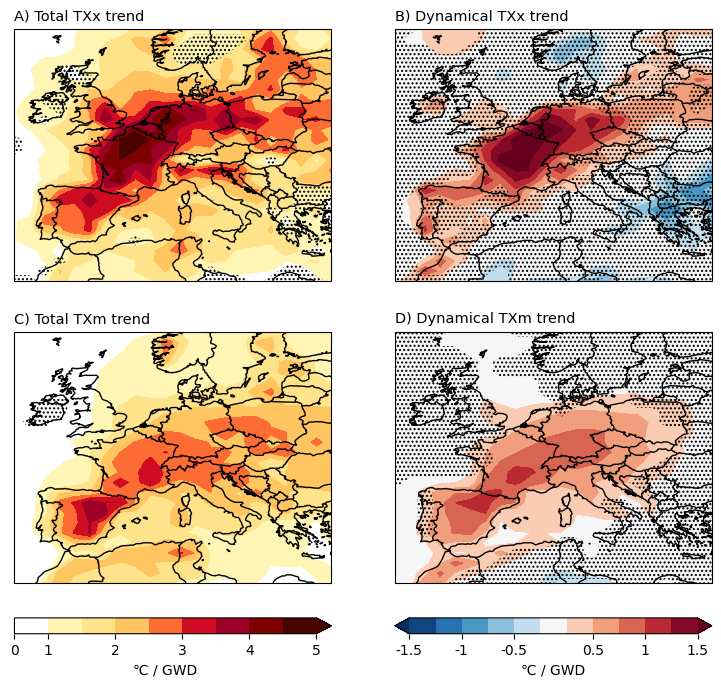

In [52]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 9), subplot_kw={'projection': ccrs.PlateCarree()})

#optie 1
levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4])
custom_colors1 = ["#ffffff","#ffffff","#fff6b6","#fee38b","#fec561","#fc6c33","#cf0c21","#9d0026"]
custom_cmap1 = mcolors.ListedColormap(custom_colors1)

#levels2 = np.array([-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25])
custom_colors2 = ["#ffffff","#fee38b","#fec561","#fd9f44","#fc6c33","#ef3323","#cf0c21","#9d0026"]
custom_cmap2 = mcolors.ListedColormap(custom_colors2)
custom_cmap2 = "RdBu_r"


levels2 = np.array([-1.5,-1.25,-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1,1.25,1.5])
custom_colors2 = ["#ffffff","#fee38b","#fec561","#fd9f44","#fc6c33","#ef3323","#cf0c21","#9d0026"]
#custom_cmap2 = mcolors.ListedColormap(hex_colors2)
custom_cmap2 = "RdBu_r"

#optie 2
# levels1 = np.linspace(0,4.5,16)
# custom_cmap1 = "YlOrRd"
# levels2 = np.array([0,0.3,0.6,0.9,1.2,1.5,1.8])
# levels2 = np.linspace(0,1.8,13)
# custom_cmap2 = "YlOrRd"
levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4,4.5,5])
#levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4,4.5,5,6])
#Vautard = ["#ffffff","#f2f3e4","#f4f4b6","#f4c460","#f38a37","#eb3923","#b80229","#7d0100","#480301"]
Vautard = ["#ffffff","#ffffff","#fff6b6","#fee38b","#fec561","#fc6c33","#cf0c21","#9d0026","#7d0100","#480301"]

custom_cmap1 = mcolors.ListedColormap(Vautard)

#ax1 = plt.axes(projection = ccrs.PlateCarree())
plot1 = ax1.contourf(lon_total_box, lat_total_box, total_Txx_b, cmap = custom_cmap1, transform = ccrs.PlateCarree(), levels = levels1,extend = "max") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax1.contourf(lon_total_box, lat_total_box,total_Txx_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.add_feature(cf.BORDERS)
ax1.set_title("A) Total TXx trend",loc="left",fontsize = 10.5)

#ax3
plot3 = ax3.contourf(lon_total_box, lat_total_box, total_Txm_b, cmap = custom_cmap1, transform = ccrs.PlateCarree(), levels = levels1,extend = "max") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax3.contourf(lon_total_box, lat_total_box,total_Txm_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.add_feature(cf.BORDERS)
ax3.set_title("C) Total TXm trend",loc="left",fontsize = 10.5)

#ax2
plot2 = ax2.contourf(lon_dynamical_box, lat_dynamical_box, dynamical_Txx_b, cmap = custom_cmap2, transform = ccrs.PlateCarree(), levels = levels2, extend= "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax2.contourf(lon_dynamical_box, lat_dynamical_box,dynamical_Txx_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.add_feature(cf.BORDERS)
ax2.set_title("B) Dynamical TXx trend",loc="left",fontsize = 10.5)


#ax4
plot4 = ax4.contourf(lon_dynamical_box, lat_dynamical_box, dynamical_Txm_b, cmap = custom_cmap2, transform = ccrs.PlateCarree(), levels = levels2, extend= "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax4.contourf(lon_dynamical_box, lat_dynamical_box,dynamical_Txm_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax4.coastlines()
ax4.add_feature(cf.BORDERS)
ax4.set_title("D) Dynamical TXm trend",loc="left",fontsize = 10.5)


cbar1 = plt.colorbar(plot1, ax=[ax1,ax3], orientation = "horizontal", label = "\N{DEGREE CELSIUS} / GWD", pad = 0.05)
cbar2 = plt.colorbar(plot4, ax=[ax2,ax4], orientation = "horizontal", label = "\N{DEGREE CELSIUS} / GWD", pad = 0.05)

cbar2.set_ticks([-1.5,-1,-0.5,0.5,1,1.5])
cbar2.set_ticklabels([-1.5,-1,-0.5,0.5,1,1.5])
cbar1.set_ticks([0,1,2,3,4,5])
cbar1.set_ticklabels([0,1,2,3,4,5])
#plt.subplots_adjust(wspace = 0.1)
plt.tight_layout # als layout() choked het alles
#plt.savefig("/usr/people/noest/stage_folders/outputs/figures_net/temperaturetrendprepped2023_sig2_labelC_JJA2.png",dpi=600)


## **Temperature trend era5 map prepped 2023 MAM anomaly**

In [49]:
#Select which region to plot
Sv = 32
Nv = 63
Wv = -13
Ev = 28

In [50]:
#Load data for total trend
os.chdir("/usr/people/noest/stage_folders/outputs/net/serious_run2/total_trend/era5")
total_Txx = np.load("MAM_anomaly_era5_TXx_slope_regridded_data_until_2023.npy")
total_Txm = np.load("MAM_anomaly_era5_TXm_slope_regridded_data_until_2023.npy")
total_lat = np.load("MAM_anomaly_era5_lat_extracted_regridded_data_until_2023.npy")
total_lon = np.load("MAM_anomaly_era5_lon_extracted_regridded_data_until_2023.npy")
total_Txx_se = np.load("MAM_anomaly_era5_TXx_stderr_regridded_data_until_2023.npy")
total_Txm_se = np.load("MAM_anomaly_era5_TXm_stderr_regridded_data_until_2023.npy")

with open("MAM_anomaly_era5_meanTxxlist_regridded_data_until_2023.pkl", 'rb') as file:  # Open in binary mode for pickled files
    total_Txx_trend = pickle.load(file)
with open("MAM_anomaly_era5_meanTxmlist_regridded_data_until_2023.pkl", 'rb') as file:  # Open in binary mode for pickled files
    total_Txm_trend = pickle.load(file)

In [51]:
#Load data for dynamical trend
os.chdir("/usr/people/noest/stage_folders/outputs/net/serious_run2/dynamical_trend/era5_prepared_psi")
dynamical_Txx = np.load("MAM_anomaly3_era5_TXx_slope_regridded_data_until_2023.npy")
dynamical_Txm = np.load("MAM_anomaly3_era5_TXm_slope_regridded_data_until_2023.npy")
dynamical_lat = np.load("MAM_anomaly3_era5_lat_extracted_regridded_data_until_2023.npy")
dynamical_lon = np.load("MAM_anomaly3_era5_lon_extracted_regridded_data_until_2023.npy")
dynamical_Txx_se = np.load("MAM_anomaly3_era5_TXx_stderr_regridded_data_until_2023.npy")
dynamical_Txm_se = np.load("MAM_anomaly3_era5_TXm_stderr_regridded_data_until_2023.npy")

with open("MAM_anomaly3_era5_meanTxxlist_regridded_data_until_2023.pkl", 'rb') as file:  # Open in binary mode for pickled files
    dynamical_Txx_trend = pickle.load(file)
with open("MAM_anomaly3_era5_meanTxmlist_regridded_data_until_2023.pkl", 'rb') as file:  # Open in binary mode for pickled files
    dynamical_Txm_trend = pickle.load(file)

In [52]:
#Calculate masks
total_Txx_mask = significance_standard_deviation(total_Txx,total_Txx_se)
total_Txm_mask = significance_standard_deviation(total_Txm,total_Txm_se)
dynamical_Txx_mask = significance_standard_deviation(dynamical_Txx,dynamical_Txx_se)
dynamical_Txm_mask = significance_standard_deviation(dynamical_Txm,dynamical_Txm_se)

In [53]:
#Extract area for total
lat_total_box,lon_total_box,total_Txx_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txx,event = True)
_,_,total_Txm_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txm,event = True)
_,_,total_Txx_mask_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txx_mask,event = True)
_,_,total_Txm_mask_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txm_mask,event = True)

In [54]:
#Extract area for dynamical
lat_dynamical_box,lon_dynamical_box,dynamical_Txx_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txx,event = True)
_,_,dynamical_Txm_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txm,event = True)
_,_,dynamical_Txx_mask_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txx_mask,event = True)
_,_,dynamical_Txm_mask_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txm_mask,event = True)

In [55]:
#Squeeze everyting for total
total_Txx_b = np.squeeze(total_Txx_b)
total_Txm_b = np.squeeze(total_Txm_b)
total_Txx_mask_b = np.squeeze(total_Txx_mask_b)
total_Txm_mask_b = np.squeeze(total_Txm_mask_b)

In [56]:
#Squeeze everyting for dynamical
dynamical_Txx_b = np.squeeze(dynamical_Txx_b)
dynamical_Txm_b = np.squeeze(dynamical_Txm_b)
dynamical_Txx_mask_b = np.squeeze(dynamical_Txx_mask_b)
dynamical_Txm_mask_b = np.squeeze(dynamical_Txm_mask_b)

In [57]:
print (total_Txx_trend)
print (total_Txm_trend)
print (dynamical_Txx_trend)
print (dynamical_Txm_trend)

[2.005521543716112]
[1.9919368646252782]
[0.393098800674043]
[0.44842561525672253]


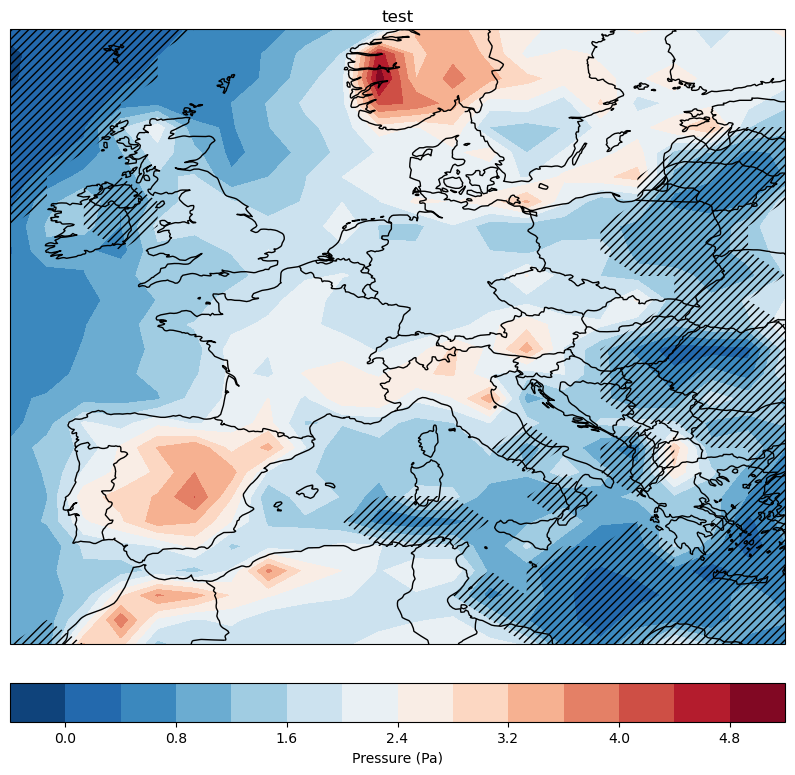

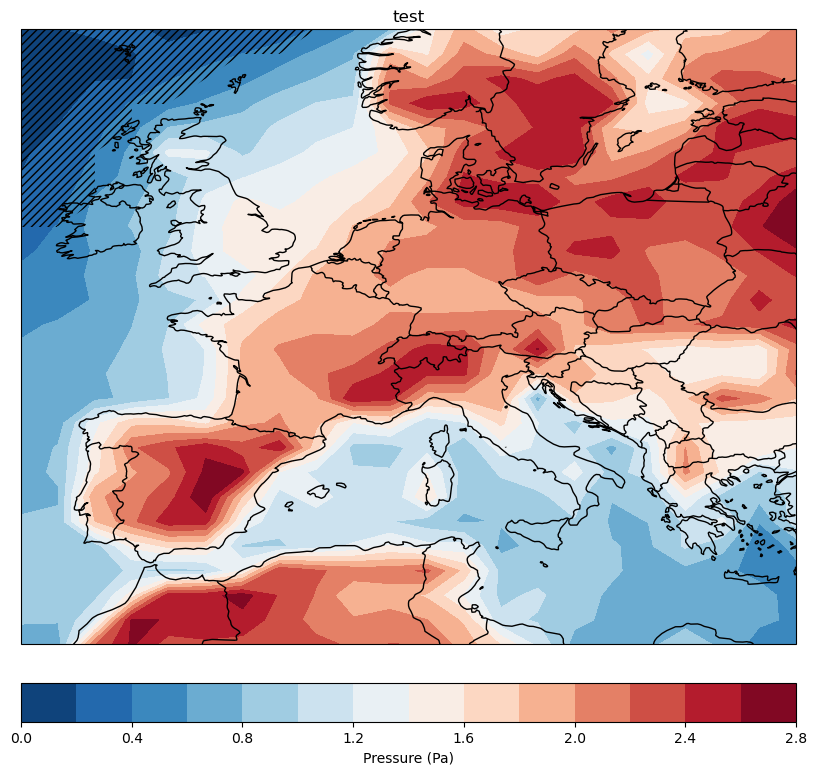

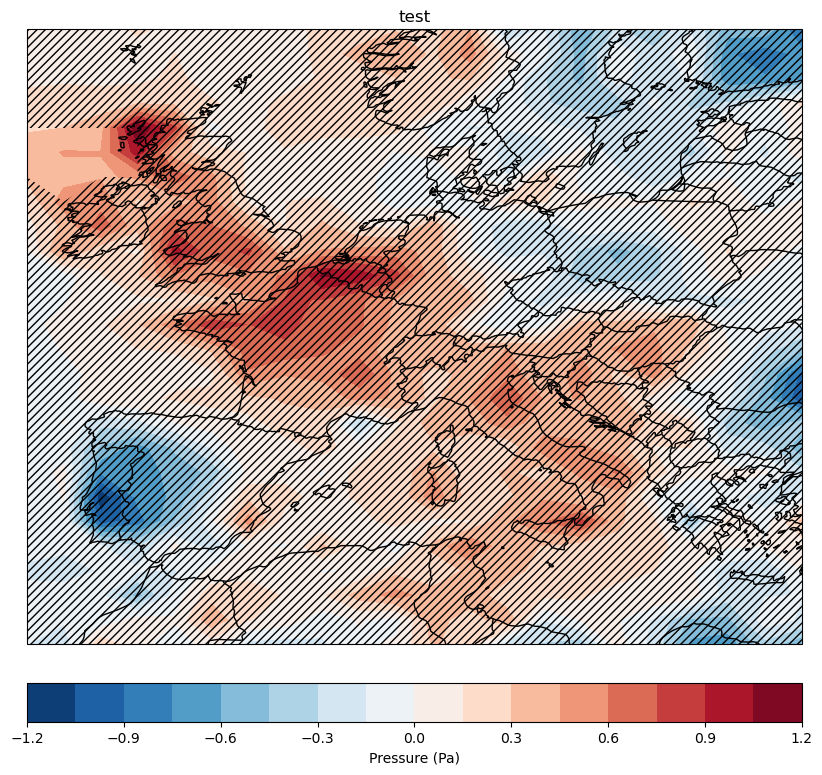

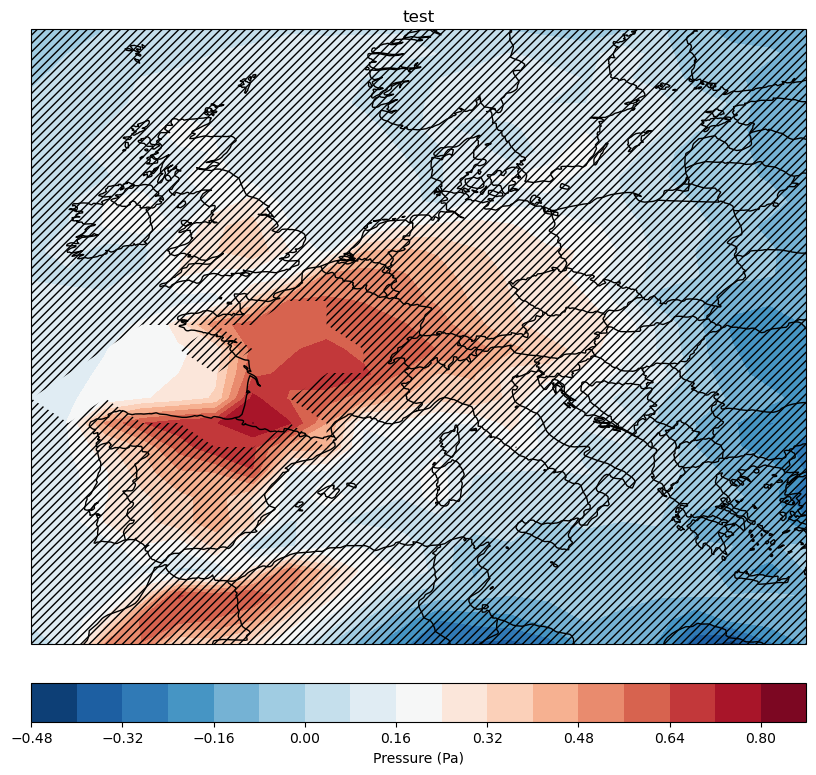

In [58]:
plot_difference(lat_total_box,lon_total_box,total_Txx_b,total_Txx_mask_b)
plot_difference(lat_total_box,lon_total_box,total_Txm_b,total_Txm_mask_b)
plot_difference(lat_dynamical_box,lon_dynamical_box,dynamical_Txx_b,dynamical_Txx_mask_b)
plot_difference(lat_dynamical_box,lon_dynamical_box,dynamical_Txm_b,dynamical_Txm_mask_b)

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

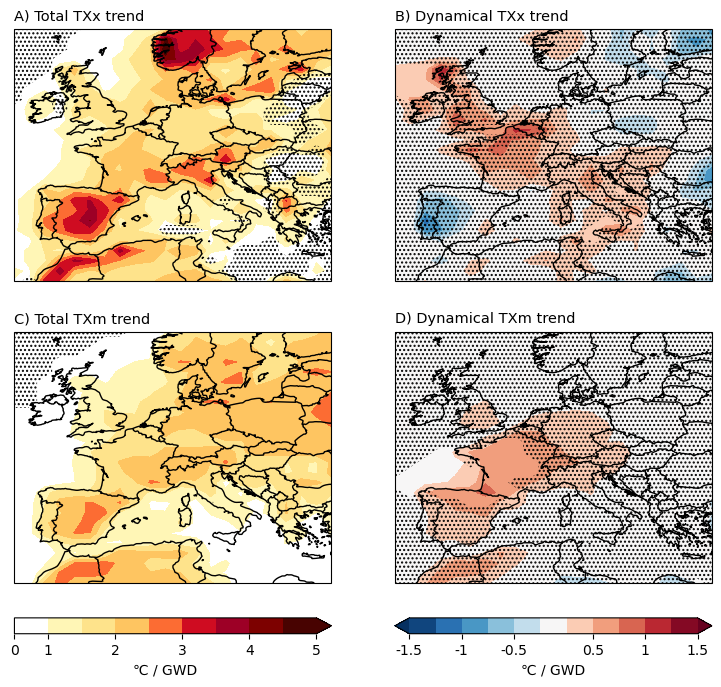

In [59]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 9), subplot_kw={'projection': ccrs.PlateCarree()})

#optie 1
levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4])
custom_colors1 = ["#ffffff","#ffffff","#fff6b6","#fee38b","#fec561","#fc6c33","#cf0c21","#9d0026"]
custom_cmap1 = mcolors.ListedColormap(custom_colors1)

#levels2 = np.array([-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25])
custom_colors2 = ["#ffffff","#fee38b","#fec561","#fd9f44","#fc6c33","#ef3323","#cf0c21","#9d0026"]
custom_cmap2 = mcolors.ListedColormap(custom_colors2)
custom_cmap2 = "RdBu_r"


levels2 = np.array([-1.5,-1.25,-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1,1.25,1.5])
custom_colors2 = ["#ffffff","#fee38b","#fec561","#fd9f44","#fc6c33","#ef3323","#cf0c21","#9d0026"]
#custom_cmap2 = mcolors.ListedColormap(hex_colors2)
custom_cmap2 = "RdBu_r"

#optie 2
# levels1 = np.linspace(0,4.5,16)
# custom_cmap1 = "YlOrRd"
# levels2 = np.array([0,0.3,0.6,0.9,1.2,1.5,1.8])
# levels2 = np.linspace(0,1.8,13)
# custom_cmap2 = "YlOrRd"
levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4,4.5,5])
#levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4,4.5,5,6])
#Vautard = ["#ffffff","#f2f3e4","#f4f4b6","#f4c460","#f38a37","#eb3923","#b80229","#7d0100","#480301"]
Vautard = ["#ffffff","#ffffff","#fff6b6","#fee38b","#fec561","#fc6c33","#cf0c21","#9d0026","#7d0100","#480301"]

custom_cmap1 = mcolors.ListedColormap(Vautard)

#ax1 = plt.axes(projection = ccrs.PlateCarree())
plot1 = ax1.contourf(lon_total_box, lat_total_box, total_Txx_b, cmap = custom_cmap1, transform = ccrs.PlateCarree(), levels = levels1,extend = "max") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax1.contourf(lon_total_box, lat_total_box,total_Txx_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.add_feature(cf.BORDERS)
ax1.set_title("A) Total TXx trend",loc="left",fontsize = 10.5)

#ax3
plot3 = ax3.contourf(lon_total_box, lat_total_box, total_Txm_b, cmap = custom_cmap1, transform = ccrs.PlateCarree(), levels = levels1,extend = "max") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax3.contourf(lon_total_box, lat_total_box,total_Txm_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.add_feature(cf.BORDERS)
ax3.set_title("C) Total TXm trend",loc="left",fontsize = 10.5)

#ax2
plot2 = ax2.contourf(lon_dynamical_box, lat_dynamical_box, dynamical_Txx_b, cmap = custom_cmap2, transform = ccrs.PlateCarree(), levels = levels2, extend= "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax2.contourf(lon_dynamical_box, lat_dynamical_box,dynamical_Txx_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.add_feature(cf.BORDERS)
ax2.set_title("B) Dynamical TXx trend",loc="left",fontsize = 10.5)


#ax4
plot4 = ax4.contourf(lon_dynamical_box, lat_dynamical_box, dynamical_Txm_b, cmap = custom_cmap2, transform = ccrs.PlateCarree(), levels = levels2, extend= "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax4.contourf(lon_dynamical_box, lat_dynamical_box,dynamical_Txm_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax4.coastlines()
ax4.add_feature(cf.BORDERS)
ax4.set_title("D) Dynamical TXm trend",loc="left",fontsize = 10.5)


cbar1 = plt.colorbar(plot1, ax=[ax1,ax3], orientation = "horizontal", label = "\N{DEGREE CELSIUS} / GWD", pad = 0.05)
cbar2 = plt.colorbar(plot4, ax=[ax2,ax4], orientation = "horizontal", label = "\N{DEGREE CELSIUS} / GWD", pad = 0.05)

cbar2.set_ticks([-1.5,-1,-0.5,0.5,1,1.5])
cbar2.set_ticklabels([-1.5,-1,-0.5,0.5,1,1.5])
cbar1.set_ticks([0,1,2,3,4,5])
cbar1.set_ticklabels([0,1,2,3,4,5])
#plt.subplots_adjust(wspace = 0.1)
plt.tight_layout # als layout() choked het alles
#plt.savefig("/usr/people/noest/stage_folders/outputs/figures_net/temperaturetrendprepped2023_sig2_labelC_anomaly3_goed.png",dpi=600)


## **Temperature trend model boxplot Hadgem**

In [60]:
#Load data for total trend
os.chdir("/usr/people/noest/stage_folders/outputs/net/serious_run2/total_trend/model_HadGem")

with open("MAM_model_meanTxxlist.pkl", 'rb') as file:  # Open in binary mode for pickled files
    total_Txx_trend_list = pickle.load(file)
with open("MAM_model_meanTxmlist.pkl", 'rb') as file:  # Open in binary mode for pickled files
    total_Txm_trend_list = pickle.load(file)

In [61]:
os.chdir("/usr/people/noest/stage_folders/outputs/net/serious_run2/total_trend/era5")

with open("MAM_era5_meanTxxlist_regridded_data_until_2014.pkl", 'rb') as file:  # Open in binary mode for pickled files
    total_Txx_trend2014 = pickle.load(file)
with open("MAM_era5_meanTxmlist_regridded_data_until_2014.pkl", 'rb') as file:  # Open in binary mode for pickled files
    total_Txm_trend2014 = pickle.load(file)

In [62]:
print (total_Txx_trend2014)
print (total_Txm_trend2014)

[2.9391906671385537]
[2.391961099239894]


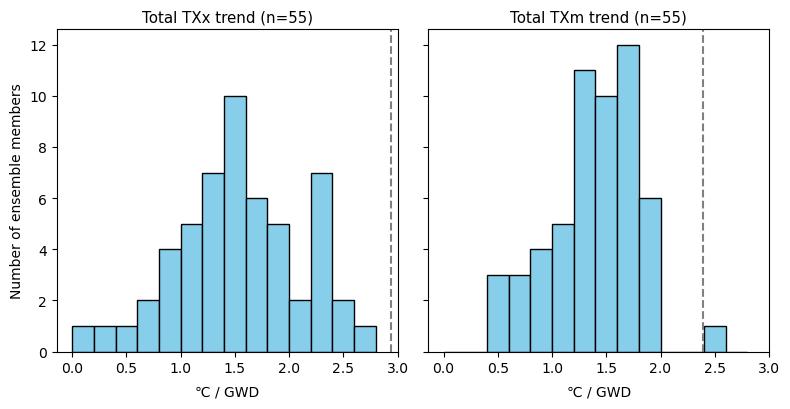

In [63]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8, 4.2),sharey=True)
years = [2018, 2019, 2020, 2021]
bins1 = np.arange(0, 3, 0.2)  # Define bins from 1850 to 2021 with a step of 10 years

ax1.hist(total_Txx_trend_list, bins=bins1, color='skyblue', edgecolor='black')  # Plot histogram skyblue
ax1.set_title("Total TXx trend (n=55)",fontsize = 10.8) # Set title for the subplot
ax1.set_xlabel('\N{DEGREE CELSIUS} / GWD',fontsize = 10, labelpad = 7)
ax1.set_ylabel('Number of ensemble members')

xticks1 = np.linspace(0,3,7)  # Set the points where you want tick labels
xticklabels1 = xticks1  # Set the corresponding labels
ax1.set_xticks(xticks1)
ax1.set_xticklabels(xticklabels1)
ax1.axvline(x=2.9391906671385537, color='grey', linestyle='--')  

ax2.hist(total_Txm_trend_list, bins=bins1, color='skyblue', edgecolor='black')  # Plot histogram
ax2.set_title("Total TXm trend (n=55)",fontsize = 10.8) # Set title for the subplot
ax2.set_xlabel("\N{DEGREE CELSIUS} / GWD",fontsize = 10, labelpad = 7)
#ax2.set_ylabel('Number of ensemble members')

xticks1 = np.linspace(0,3,7)  # Set the points where you want tick labels
xticklabels1 = xticks1  # Set the corresponding labels
ax2.set_xticks(xticks1)
ax2.set_xticklabels(xticklabels1)
ax2.axvline(x=2.391961099239894, color='grey', linestyle='--') 

#fig.text(0.52, -0.02, 'Trend', ha='center', va='center')

#plt.subplots_adjust(bottom=0.1, top=0.8)

plt.tight_layout()
#plt.savefig("/usr/people/noest/stage_folders/outputs/figures_tussentijdse_presentatie/totaltrendmodel2014.png",dpi=600)
plt.show()

In [64]:
txx_counter = 0
for getal in total_Txx_trend_list:
    if getal >= 2.9391906671385537:
        txx_counter = txx_counter + 1
print (f"the amount of ensemble members with a high enough TXx trend is {txx_counter}")
array_txx = np.array(total_Txx_trend_list)
print (f"the max Txx model trend is {np.max(array_txx)} and the mean is {np.mean(array_txx)}")
print (f"the st dev is {np.std(array_txx)} so the 95 level threshold is {(np.mean(array_txx))+(2*(np.std(array_txx)))}")

the amount of ensemble members with a high enough TXx trend is 0
the max Txx model trend is 2.8430612989841992 and the mean is 1.5703508153531076
the st dev is 0.593718381106353 so the 95 level threshold is 2.7577875775658134


In [65]:
txm_counter = 0
for getal in total_Txm_trend_list:
    if getal >= 2.391961099239894:
        txm_counter = txm_counter + 1
print (f"the amount of ensemble members with a high enough TXx trend is {txm_counter}")
array_txm = np.array(total_Txm_trend_list)
print (f"the max Txm model trend is {np.max(array_txm)} and the mean is {np.mean(array_txm)}")
print (f"the st dev is {np.std(array_txm)} so the 95 level threshold is {(np.mean(array_txm))+(2*(np.std(array_txm)))}")

the amount of ensemble members with a high enough TXx trend is 1
the max Txm model trend is 2.4059147786857484 and the mean is 1.3821414257795153
the st dev is 0.3935461407758997 so the 95 level threshold is 2.1692337073313146


## **Temperature trend model boxplot MIROC**

In [66]:
#Load data for total trend
os.chdir("/usr/people/noest/stage_folders/outputs/net/serious_run2/total_trend/model_MIROC")

with open("MAM_model_meanTxxlist.pkl", 'rb') as file:  # Open in binary mode for pickled files
    total_Txx_trend_list = pickle.load(file)
with open("MAM_model_meanTxmlist.pkl", 'rb') as file:  # Open in binary mode for pickled files
    total_Txm_trend_list = pickle.load(file)

In [67]:
os.chdir("/usr/people/noest/stage_folders/outputs/net/serious_run2/total_trend/era5")

with open("MAM_era5_meanTxxlist_regridded_data_until_2014.pkl", 'rb') as file:  # Open in binary mode for pickled files
    total_Txx_trend2014 = pickle.load(file)
with open("MAM_era5_meanTxmlist_regridded_data_until_2014.pkl", 'rb') as file:  # Open in binary mode for pickled files
    total_Txm_trend2014 = pickle.load(file)

In [68]:
print (total_Txx_trend2014)
print (total_Txm_trend2014)

[2.9391906671385537]
[2.391961099239894]


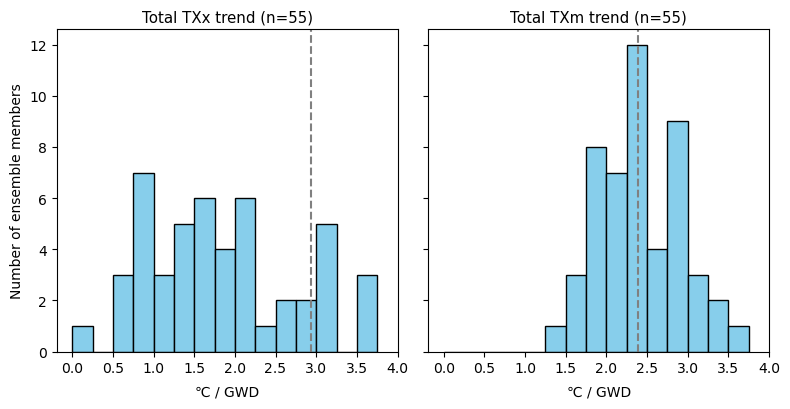

In [69]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8, 4.2),sharey=True)
years = [2018, 2019, 2020, 2021]
bins1 = np.arange(0, 4, 0.25)  # Define bins from 1850 to 2021 with a step of 10 years

ax1.hist(total_Txx_trend_list, bins=bins1, color='skyblue', edgecolor='black')  # Plot histogram skyblue
ax1.set_title("Total TXx trend (n=55)",fontsize = 10.8) # Set title for the subplot
ax1.set_xlabel('\N{DEGREE CELSIUS} / GWD',fontsize = 10, labelpad = 7)
ax1.set_ylabel('Number of ensemble members')

xticks1 = np.linspace(0,4,9)  # Set the points where you want tick labels
xticklabels1 = xticks1  # Set the corresponding labels
ax1.set_xticks(xticks1)
ax1.set_xticklabels(xticklabels1)
ax1.axvline(x=2.9391906671385537, color='grey', linestyle='--')  

ax2.hist(total_Txm_trend_list, bins=bins1, color='skyblue', edgecolor='black')  # Plot histogram
ax2.set_title("Total TXm trend (n=55)",fontsize = 10.8) # Set title for the subplot
ax2.set_xlabel("\N{DEGREE CELSIUS} / GWD",fontsize = 10, labelpad = 7)
#ax2.set_ylabel('Number of ensemble members')

xticks1 = np.linspace(0,4,9)  # Set the points where you want tick labels
xticklabels1 = xticks1  # Set the corresponding labels
ax2.set_xticks(xticks1)
ax2.set_xticklabels(xticklabels1)
ax2.axvline(x=2.391961099239894, color='grey', linestyle='--') 

#fig.text(0.52, -0.02, 'Trend', ha='center', va='center')

#plt.subplots_adjust(bottom=0.1, top=0.8)

plt.tight_layout()
#plt.savefig("/usr/people/noest/stage_folders/outputs/figures_tussentijdse_presentatie/totaltrendmodel2014.png",dpi=600)
plt.show()

In [70]:
txx_counter = 0
for getal in total_Txx_trend_list:
    if getal >= 2.9391906671385537:
        txx_counter = txx_counter + 1
print (f"the amount of ensemble members with a high enough TXx trend is {txx_counter}")
array_txx = np.array(total_Txx_trend_list)
print (f"the max Txx model trend is {np.max(array_txx)} and the mean is {np.mean(array_txx)}")

the amount of ensemble members with a high enough TXx trend is 10
the max Txx model trend is 3.9254889870141576 and the mean is 1.8347830202870774


In [71]:
txm_counter = 0
for getal in total_Txm_trend_list:
    if getal >= 2.391961099239894:
        txm_counter = txm_counter + 1
print (f"the amount of ensemble members with a high enough TXx trend is {txm_counter}")
array_txm = np.array(total_Txm_trend_list)
print (f"the max Txm model trend is {np.max(array_txm)} and the mean is {np.mean(array_txm)}")

the amount of ensemble members with a high enough TXx trend is 25
the max Txm model trend is 3.74536164511341 and the mean is 2.424733584624899


## **Temperature trend model boxplot combined**

In [72]:
#Load data for total trend
os.chdir("/usr/people/noest/stage_folders/outputs/net/serious_run2/total_trend/model_HadGem")

with open("MAM_model_meanTxxlist.pkl", 'rb') as file:  # Open in binary mode for pickled files
    total_Txx_trend_listH = pickle.load(file)
with open("MAM_model_meanTxmlist.pkl", 'rb') as file:  # Open in binary mode for pickled files
    total_Txm_trend_listH = pickle.load(file)

In [73]:
#Load data for total trend
os.chdir("/usr/people/noest/stage_folders/outputs/net/serious_run2/total_trend/model_MIROC")

with open("MAM_model_meanTxxlist.pkl", 'rb') as file:  # Open in binary mode for pickled files
    total_Txx_trend_listM = pickle.load(file)
with open("MAM_model_meanTxmlist.pkl", 'rb') as file:  # Open in binary mode for pickled files
    total_Txm_trend_listM = pickle.load(file)

In [74]:
total_Txx_trend_listC = total_Txx_trend_listH + total_Txx_trend_listM
total_Txm_trend_listC = total_Txm_trend_listH + total_Txm_trend_listM

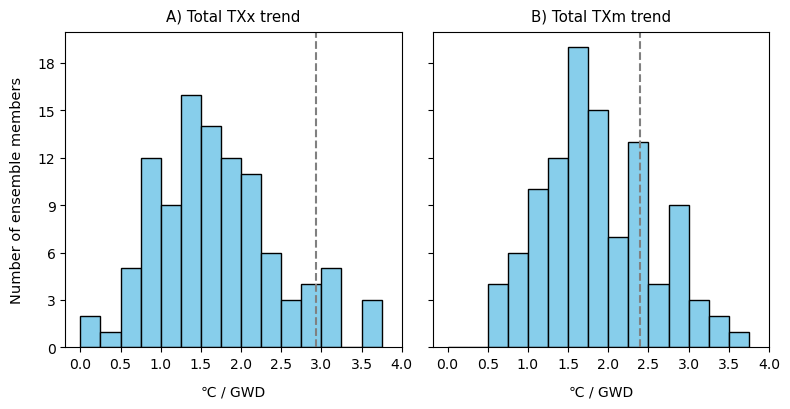

In [75]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8, 4.2),sharey=True)
years = [2018, 2019, 2020, 2021]
bins1 = np.arange(0, 4, 0.25)  # Define bins from 1850 to 2021 with a step of 10 years

ax1.hist(total_Txx_trend_listC, bins=bins1, color='skyblue', edgecolor='black')  # Plot histogram skyblue
ax1.set_title("A) Total TXx trend",fontsize = 10.8, pad = 8) # Set title for the subplot
ax1.set_xlabel('\N{DEGREE CELSIUS} / GWD',fontsize = 10, labelpad = 10)
ax1.set_ylabel('Number of ensemble members', fontsize = 10.5, labelpad = 10)

xticks1 = np.linspace(0,4,9)  # Set the points where you want tick labels
xticklabels1 = xticks1  # Set the corresponding labels
ax1.set_xticks(xticks1)
ax1.set_xticklabels(xticklabels1)
ax1.axvline(x=2.9391906671385537, color='grey', linestyle='--') 

yticks = np.linspace(0,18,7)
y_labels = [0,3,6,9,12,15,18]
ax1.set_yticks(yticks)
ax1.set_yticklabels(y_labels)

ax2.hist(total_Txm_trend_listC, bins=bins1, color='skyblue', edgecolor='black')  # Plot histogram
ax2.set_title("B) Total TXm trend",fontsize = 10.8, pad = 8) # Set title for the subplot
ax2.set_xlabel("\N{DEGREE CELSIUS} / GWD",fontsize = 10, labelpad = 10)
#ax2.set_ylabel('Number of ensemble members')

xticks1 = np.linspace(0,4,9)  # Set the points where you want tick labels
xticklabels1 = xticks1  # Set the corresponding labels
ax2.set_xticks(xticks1)
ax2.set_xticklabels(xticklabels1)
ax2.axvline(x=2.391961099239894, color='grey', linestyle='--') 

#yticks = np.linspace(0,20,6)
ax2.set_yticks(yticks)
ax2.set_yticklabels(y_labels)
#fig.text(0.52, -0.02, 'Trend', ha='center', va='center')

#plt.subplots_adjust(bottom=0.1, top=0.8)

plt.tight_layout()
#plt.savefig("/usr/people/noest/stage_folders/outputs/figures_net/model_trend_combined_y_as_fonts2.png",dpi=600)
plt.show()

In [76]:
txx_counter = 0
for getal in total_Txx_trend_listC:
    if getal >= 2.9391906671385537:
        txx_counter = txx_counter + 1
print (f"the amount of ensemble members with a high enough TXx trend is {txx_counter}")
array_txx = np.array(total_Txx_trend_listC)
print (f"the max Txx model trend is {np.max(array_txx)} and the mean is {np.mean(array_txx)}")
print (f"the st dev is {np.std(array_txx)} so the 95 level threshold is {(np.mean(array_txx))+(2*(np.std(array_txx)))}")

the amount of ensemble members with a high enough TXx trend is 10
the max Txx model trend is 3.9254889870141576 and the mean is 1.696270912940712
the st dev is 0.8226518716270669 so the 95 level threshold is 3.3415746561948456


In [77]:
txm_counter = 0
for getal in total_Txm_trend_listC:
    if getal >= 2.391961099239894:
        txm_counter = txm_counter + 1
print (f"the amount of ensemble members with a high enough TXx trend is {txm_counter}")
array_txm = np.array(total_Txm_trend_listC)
print (f"the max Txm model trend is {np.max(array_txm)} and the mean is {np.mean(array_txm)}")
print (f"the st dev is {np.std(array_txm)} so the 95 level threshold is {(np.mean(array_txm))+(2*(np.std(array_txm)))}")

the amount of ensemble members with a high enough TXx trend is 26
the max Txm model trend is 3.74536164511341 and the mean is 1.878613882372555
the st dev is 0.6862620960053407 so the 95 level threshold is 3.2511380743832365


In [1]:
# print (total_Txx_trend_listM[0])
# print (total_Txm_trend_listM[0])

In [2]:
# print (total_Txx_trend_listM)
# print (total_Txm_trend_listM)

## **Method/event plaatje**

In [80]:
event = np.load("/usr/people/noest/stage_folders/event_data/Vautard_southerlyflow_2019-06-29_regridded_streamfunction_data_at_index_25381.npy")
lat,lon,_ = load_data("/net/pc200246/nobackup/users/noest/ERA5_regridded/era5_psi500_daily_regridded_1950_2023.nc","lat","lon","stream")
lat_box,lon_box,event_box = extract_area(15,75,-58,48,lat,lon,event,event = True)
event_box_prepped = prep_streamfunction(event_box)

In [81]:
from matplotlib.patches import Polygon

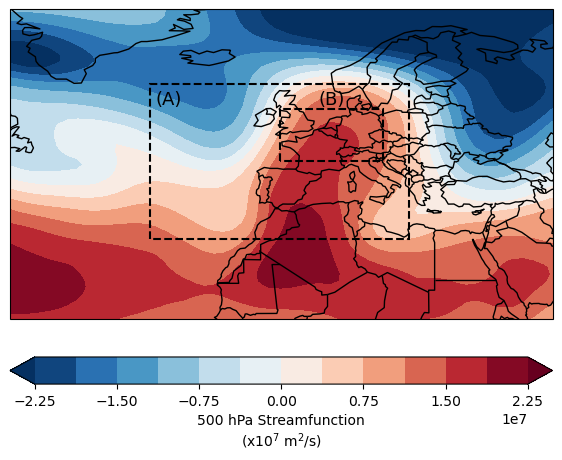

In [82]:
plt.figure(figsize = (7,7))
ax = plt.axes(projection = ccrs.PlateCarree())
plot = plt.contourf(lon_box, lat_box, event_box_prepped[0], cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = np.linspace(-2.25*1e7,2.25*1e7,13),extend = "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax.coastlines()
ax.add_feature(cf.BORDERS)
#ax.set_title(title)
plt.colorbar(plot, ax=ax, orientation = "horizontal", label = "500 hPa Streamfunction\n(x$10^7$ m$^2$/s)", pad = 0.07)

# Define the corners of the box
box_coords = [
    (-30, 30),
    (-30, 60),
    (20, 60),
    (20, 30),
    (-30, 30)  # Closing the box
]

# Create a Polygon patch
polygon = Polygon(box_coords, closed=True, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree(), linestyle= "--",linewidth = 1.5)

# Add the polygon to the plot
ax.add_patch(polygon)

# Define the corners of the box
box_coords2 = [
    (-5, 45),
    (-5, 55),
    (15, 55),
    (15, 45),
    (-5, 45)  # Closing the box
]

# Create a Polygon patch
polygon2 = Polygon(box_coords2, closed=True, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree(), linestyle= "--",linewidth = 1.5)

# Add the polygon to the plot
ax.add_patch(polygon2)

ax.text(-30 + 1, 60 - 4, '(A)', transform=ccrs.PlateCarree(), fontsize=13, color='black') #-29,56
ax.text(5, 57, '(B)', transform=ccrs.PlateCarree(), fontsize=13, color='black',ha = "center",va = "center") #3 , 47.5 of 5,57


#plt.savefig("/usr/people/noest/stage_folders/outputs/figures_net/method_event_optie2_2_font.png",dpi=600)
plt.show()
plt.close()

## **Model underestimation map**

In [85]:
#Select which region to plot
Sv = 32
Nv = 63
Wv = -13
Ev = 28

In [86]:
#Load data for total trend
os.chdir("/usr/people/noest/stage_folders/outputs/net/serious_run2/total_trend/era5")
total_Txx = np.load("MAM_era5_TXx_slope_regridded_data_until_2014.npy")
total_Txm = np.load("MAM_era5_TXm_slope_regridded_data_until_2014.npy")
total_lat = np.load("MAM_era5_lat_extracted_regridded_data_until_2014.npy")
total_lon = np.load("MAM_era5_lon_extracted_regridded_data_until_2014.npy")

In [87]:
#Extract area for total
lat_total_box,lon_total_box,total_Txx_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txx,event = True)
_,_,total_Txm_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,total_Txm,event = True)

In [88]:
#Squeeze everyting for total
total_Txx_b = np.squeeze(total_Txx_b)
total_Txm_b = np.squeeze(total_Txm_b)

In [89]:
os.chdir("/usr/people/noest/stage_folders/outputs/net/serious_run2/total_trend/model_HadGem")
had_txx = np.load("MAM_TXx_all_ensembles.npy")
had_txm = np.load("MAM_TXm_all_ensembles.npy")
_,_,had_txx_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,had_txx,event = False)
_,_,had_txm_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,had_txm,event = False)


In [90]:
os.chdir("/usr/people/noest/stage_folders/outputs/net/serious_run2/total_trend/model_MIROC")
mir_txx = np.load("MAM_TXx_all_ensembles.npy")
mir_txm = np.load("MAM_TXm_all_ensembles.npy")
_,_,mir_txx_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,mir_txx,event = False)
_,_,mir_txm_b = extract_area(Sv,Nv,Wv,Ev,total_lat,total_lon,mir_txm,event = False)

In [91]:
model_txx = np.concatenate((had_txx_b,mir_txx_b),axis=0)
model_txm = np.concatenate((had_txm_b,mir_txm_b),axis=0)

In [92]:
print (model_txm.shape,model_txx.shape,total_Txx_b.shape)

(105, 26, 22) (105, 26, 22) (26, 22)


In [93]:
value_array_txx = np.zeros((total_Txx_b.shape[0],total_Txx_b.shape[1]))

for a in range(model_txm.shape[1]):
    for b in range(model_txm.shape[2]):
        list_for_cell = []
        obs = total_Txx_b[a,b]
        values_ensembles = model_txx[:,a,b]
        for value in values_ensembles:
            if value >= obs:
                list_for_cell.append(1)
        percentage = ((len(list_for_cell))/(len(values_ensembles)))*100
        value_array_txx[a,b] = percentage

In [94]:
value_array_txm = np.zeros((total_Txx_b.shape[0],total_Txx_b.shape[1]))

for a in range(model_txm.shape[1]):
    for b in range(model_txm.shape[2]):
        list_for_cell = []
        obs = total_Txm_b[a,b]
        values_ensembles = model_txm[:,a,b]
        for value in values_ensembles:
            if value >= obs:
                list_for_cell.append(1)
        percentage = ((len(list_for_cell))/(len(values_ensembles)))*100
        value_array_txm[a,b] = percentage

In [95]:
#plot_variable_normal(lat_total_box,lon_total_box,value_array_txm,"test")

In [96]:
meanTxx = np.mean(model_txx,axis = 0)
meanTxm = np.mean(model_txm,axis = 0)
stdTxx = np.std(model_txx,axis = 0)
stdTxm = np.std(model_txm,axis = 0)

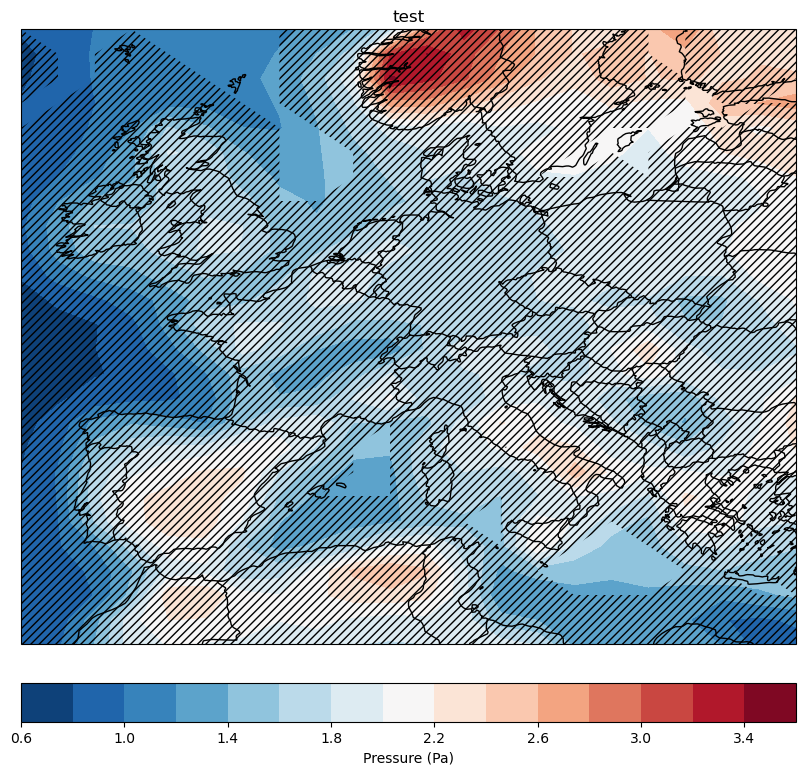

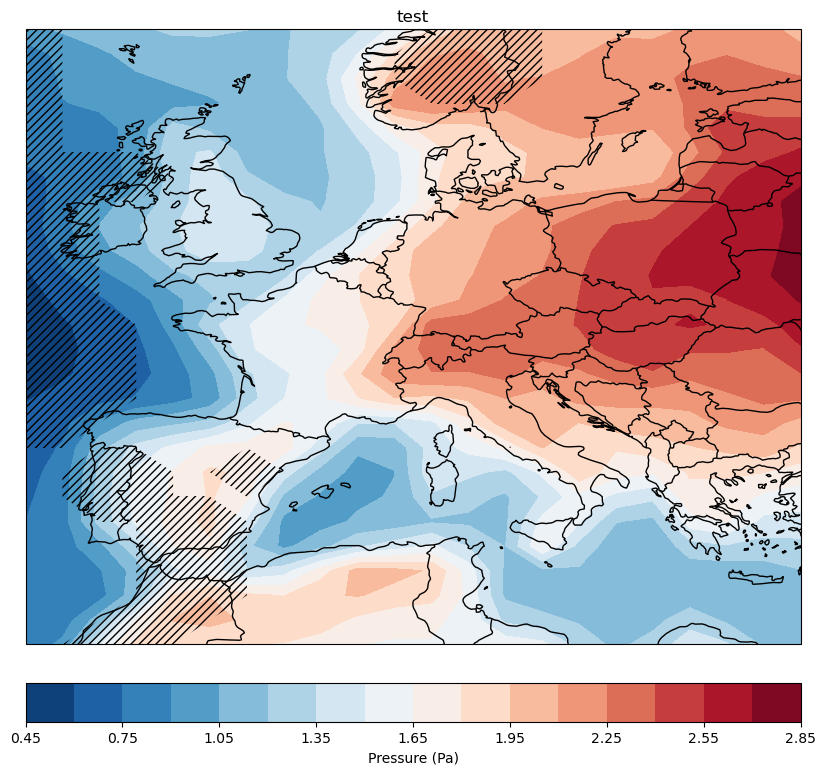

In [97]:
masktxx = significance_standard_deviation(meanTxx,stdTxx)
masktxm = significance_standard_deviation(meanTxm,stdTxm)
plot_difference(lat_total_box,lon_total_box,meanTxx,masktxx)
plot_difference(lat_total_box,lon_total_box,meanTxm,masktxm)

In [6]:
# print ((np.max(model_txx)),(np.max(meanTxx)),(np.max(total_Txx_b)))

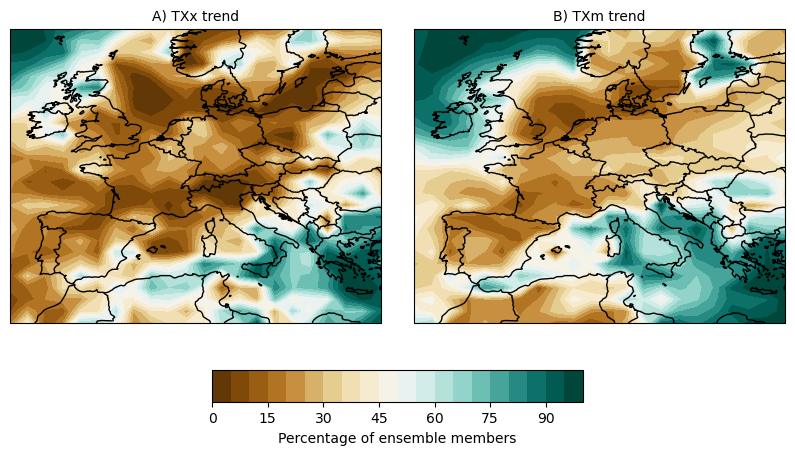

In [99]:
fig = plt.figure(figsize = (10,5))
gs = GridSpec(2, 4, figure=fig, height_ratios=[1, 0.1], width_ratios=[1, 1,1,1])

levels1 = np.linspace(0,100,21)
cmap1 = "RdYlGn"
cmap1 = "BrBG"

ax1 = fig.add_subplot(gs[0, 0:2],projection=ccrs.PlateCarree())
contour1 = ax1.contourf(lon_total_box, lat_total_box, value_array_txx, cmap = cmap1, transform = ccrs.PlateCarree(), levels = levels1) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax1.coastlines()
ax1.add_feature(cf.BORDERS)
ax1.set_title("A) TXx trend",fontsize = 10)

ax2 = fig.add_subplot(gs[0, 2:],projection=ccrs.PlateCarree())
contour2 = ax2.contourf(lon_total_box, lat_total_box, value_array_txm, cmap = cmap1, transform = ccrs.PlateCarree(), levels = levels1) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax2.coastlines()
ax2.add_feature(cf.BORDERS)
ax2.set_title("B) TXm trend",fontsize = 10)

cax1 = fig.add_subplot(gs[1,1:3])
plt.colorbar(contour1, cax=cax1, orientation="horizontal", label="Percentage of ensemble members")
#plt.savefig("/usr/people/noest/stage_folders/outputs/figures_net/underestimation_total_trend_label5.png",dpi=600)
plt.show()
plt.close()


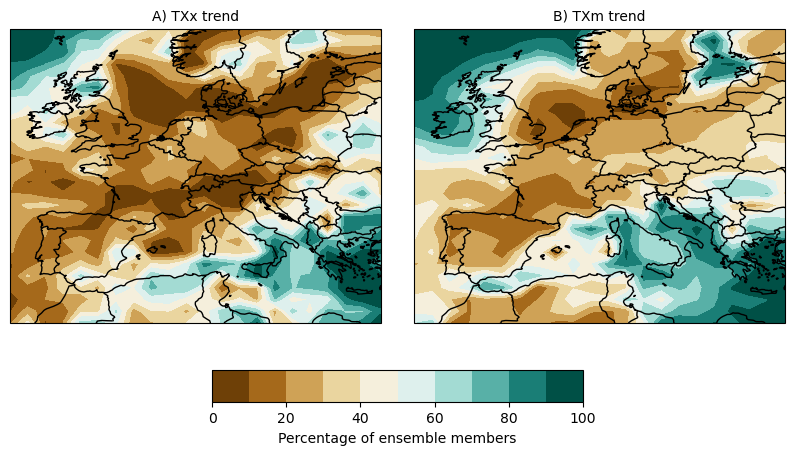

In [100]:
fig = plt.figure(figsize = (10,5))
gs = GridSpec(2, 4, figure=fig, height_ratios=[1, 0.1], width_ratios=[1, 1,1,1])

levels1 = np.linspace(0,100,11)
cmap1 = "RdYlGn"
cmap1 = "BrBG"

ax1 = fig.add_subplot(gs[0, 0:2],projection=ccrs.PlateCarree())
contour1 = ax1.contourf(lon_total_box, lat_total_box, value_array_txx, cmap = cmap1, transform = ccrs.PlateCarree(), levels = levels1) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax1.coastlines()
ax1.add_feature(cf.BORDERS)
ax1.set_title("A) TXx trend",fontsize = 10)

ax2 = fig.add_subplot(gs[0, 2:],projection=ccrs.PlateCarree())
contour2 = ax2.contourf(lon_total_box, lat_total_box, value_array_txm, cmap = cmap1, transform = ccrs.PlateCarree(), levels = levels1) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax2.coastlines()
ax2.add_feature(cf.BORDERS)
ax2.set_title("B) TXm trend",fontsize = 10)

cax1 = fig.add_subplot(gs[1,1:3])
plt.colorbar(contour1, cax=cax1, orientation="horizontal", label="Percentage of ensemble members")
#plt.savefig("/usr/people/noest/stage_folders/outputs/figures_net/underestimation_total_trend_label5.png",dpi=600)
plt.show()
plt.close()


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

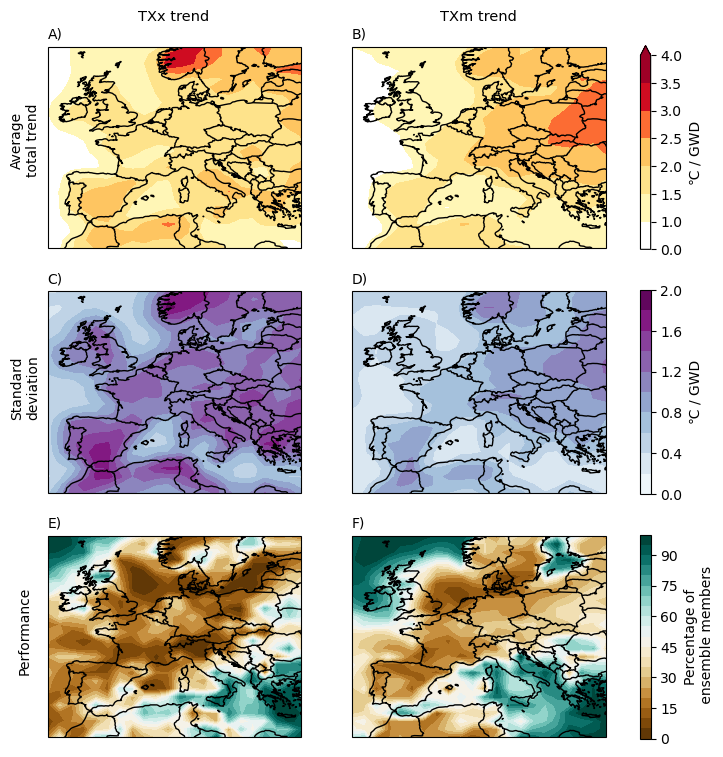

In [101]:
fig, ((ax1, ax2), (ax3, ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(9, 9), subplot_kw={'projection': ccrs.PlateCarree()})

#optie 1
levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4])
custom_colors1 = ["#ffffff","#ffffff","#fff6b6","#fee38b","#fec561","#fc6c33","#cf0c21","#9d0026"]
custom_cmap1 = mcolors.ListedColormap(custom_colors1)

# levels2 = np.array([-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25])
# custom_colors2 = ["#ffffff","#fee38b","#fec561","#fd9f44","#fc6c33","#ef3323","#cf0c21","#9d0026"]
# custom_cmap2 = mcolors.ListedColormap(custom_colors2)
# custom_cmap2 = "RdBu_r"

#optie 2
# levels1 = np.linspace(0,4.5,16)
# custom_cmap1 = "YlOrRd"
# levels2 = np.array([0,0.3,0.6,0.9,1.2,1.5,1.8])
# levels2 = np.linspace(0,1.8,13)
# custom_cmap2 = "YlOrRd"

#ax1 = plt.axes(projection = ccrs.PlateCarree())
plot1 = ax1.contourf(lon_total_box, lat_total_box, meanTxx, cmap = custom_cmap1, transform = ccrs.PlateCarree(), levels = levels1,extend = "max") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
#ax1.contourf(lon_total_box, lat_total_box,total_Txx_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.add_feature(cf.BORDERS)
#ax1.set_title("TXx trend",loc="center",fontsize = 10.5)
ax1.set_title("A)",loc="left",fontsize = 10)

#ax2
plot2 = ax2.contourf(lon_total_box, lat_total_box, meanTxm,cmap = custom_cmap1, transform = ccrs.PlateCarree(), levels = levels1,extend = "max") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
#ax2.contourf(lon_dynamical_box, lat_dynamical_box,dynamical_Txx_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.add_feature(cf.BORDERS)
#ax2.set_title("TXm trend",loc="center",fontsize = 10.5)
ax2.set_title("B)",loc="left",fontsize = 10)

levels2 = np.linspace(0,2,11)
cmap2 = "BuPu"
#ax3
plot3 = ax3.contourf(lon_total_box, lat_total_box, stdTxx, cmap = cmap2, transform = ccrs.PlateCarree(), levels = levels2) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
#ax3.contourf(lon_total_box, lat_total_box,total_Txm_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.add_feature(cf.BORDERS)
ax3.set_title("C)",loc="left",fontsize = 10)



#ax4
plot4 = ax4.contourf(lon_total_box, lat_total_box, stdTxm, cmap = cmap2, transform = ccrs.PlateCarree(), levels = levels2) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
#ax4.contourf(lon_dynamical_box, lat_dynamical_box,dynamical_Txm_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax4.coastlines()
ax4.add_feature(cf.BORDERS)
ax4.set_title("D)",loc="left",fontsize = 10)


cbar1 = plt.colorbar(plot1, ax=[ax1,ax2], orientation = "vertical", label = "\N{DEGREE CELSIUS} / GWD", pad = 0.05)
cbar2 = plt.colorbar(plot4, ax=[ax3,ax4], orientation = "vertical", label = "\N{DEGREE CELSIUS} / GWD", pad = 0.05)


levels3 = np.linspace(0,100,21)
cmap1 = "RdYlGn"
cmap3 = "BrBG"

#ax5 = fig.add_subplot(gs[0, 0:2],projection=ccrs.PlateCarree())
contour5 = ax5.contourf(lon_total_box, lat_total_box, value_array_txx, cmap = cmap3, transform = ccrs.PlateCarree(), levels = levels3) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax5.coastlines()
ax5.add_feature(cf.BORDERS)
ax5.set_title("E)",fontsize = 10,loc = "left")

#ax2 = fig.add_subplot(gs[0, 2:],projection=ccrs.PlateCarree())
contour6 = ax6.contourf(lon_total_box, lat_total_box, value_array_txm, cmap = cmap3, transform = ccrs.PlateCarree(), levels = levels3) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax6.coastlines()
ax6.add_feature(cf.BORDERS)
ax6.set_title("F)",fontsize = 10,loc = "left")

#cax1 = fig.add_subplot(gs[1,1:3])
#plt.colorbar(contour6, cax=ax6, orientation="vertical", label="Percentage of ensemble members")
cbar3 = plt.colorbar(contour6, ax=[ax5,ax6], orientation = "vertical", label = "Percentage of\n ensemble members", pad = 0.05)

fig.text(0.1, 0.775, 'Average\ntotal trend', va='center', ha='center', rotation='vertical', fontsize=10)
fig.text(0.1, 0.5, 'Standard\ndeviation', va='center', ha='center', rotation='vertical', fontsize=10)
fig.text(0.1, 0.23, 'Performance', va='center', ha='center', rotation='vertical', fontsize=10)

fig.text(0.265, 0.912, 'TXx trend', va='center', ha='center', rotation='horizontal', fontsize=10.5)
fig.text(0.604, 0.912, 'TXm trend', va='center', ha='center', rotation='horizontal', fontsize=10.5)

#plt.subplots_adjust(wspace = 0.1)
plt.tight_layout # als layout() choked het alles
#plt.savefig("/usr/people/noest/stage_folders/outputs/figures_net/model_performance_label2014.png",dpi=600)


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

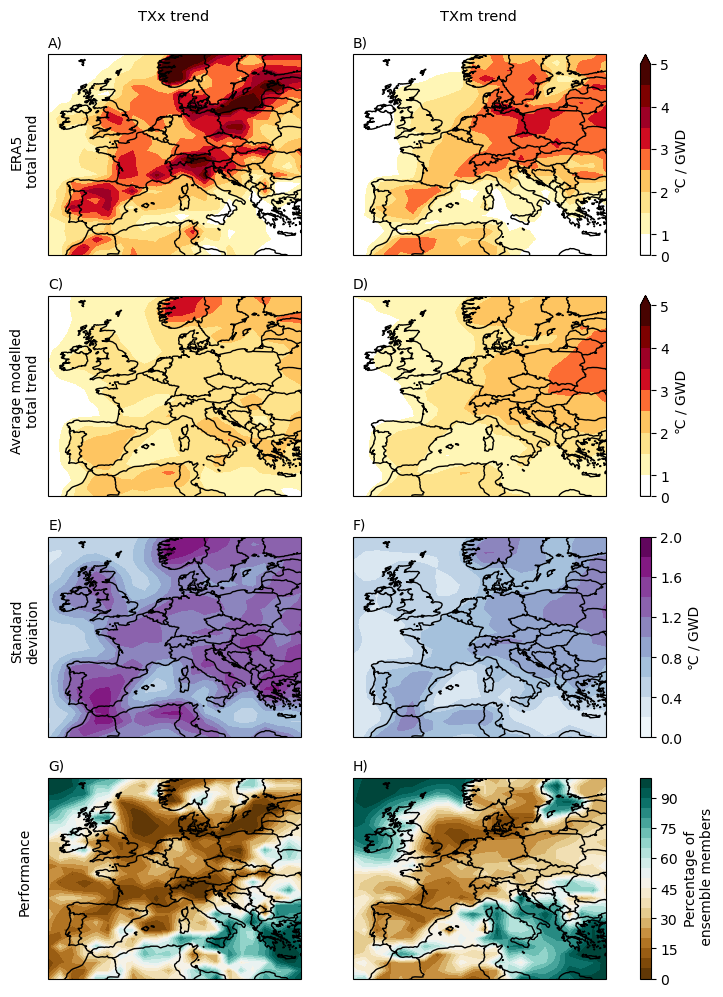

In [102]:
fig, ((ax1, ax2), (ax3, ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(nrows=4, ncols=2, figsize=(9, 12), subplot_kw={'projection': ccrs.PlateCarree()})

#optie 1
levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4])
custom_colors1 = ["#ffffff","#ffffff","#fff6b6","#fee38b","#fec561","#fc6c33","#cf0c21","#9d0026"]
custom_cmap1 = mcolors.ListedColormap(custom_colors1)

levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4,4.5,5])
#levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4,4.5,5,6])
#Vautard = ["#ffffff","#f2f3e4","#f4f4b6","#f4c460","#f38a37","#eb3923","#b80229","#7d0100","#480301"]
Vautard = ["#ffffff","#ffffff","#fff6b6","#fee38b","#fec561","#fc6c33","#cf0c21","#9d0026","#7d0100","#480301"]

custom_cmap1 = mcolors.ListedColormap(Vautard)
# levels2 = np.array([-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25])
# custom_colors2 = ["#ffffff","#fee38b","#fec561","#fd9f44","#fc6c33","#ef3323","#cf0c21","#9d0026"]
# custom_cmap2 = mcolors.ListedColormap(custom_colors2)
# custom_cmap2 = "RdBu_r"

#optie 2
# levels1 = np.linspace(0,4.5,16)
# custom_cmap1 = "YlOrRd"
# levels2 = np.array([0,0.3,0.6,0.9,1.2,1.5,1.8])
# levels2 = np.linspace(0,1.8,13)
# custom_cmap2 = "YlOrRd"

#ax1 = plt.axes(projection = ccrs.PlateCarree())
plot9 = ax1.contourf(lon_total_box, lat_total_box, total_Txx_b, cmap = custom_cmap1, transform = ccrs.PlateCarree(), levels = levels1,extend = "max") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
#ax1.contourf(lon_total_box, lat_total_box,total_Txx_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.add_feature(cf.BORDERS)
#ax1.set_title("TXx trend",loc="center",fontsize = 10.5)
ax1.set_title("A)",loc="left",fontsize = 10)

#ax1 = plt.axes(projection = ccrs.PlateCarree())
plot10 = ax2.contourf(lon_total_box, lat_total_box, total_Txm_b, cmap = custom_cmap1, transform = ccrs.PlateCarree(), levels = levels1,extend = "max") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
#ax2.contourf(lon_total_box, lat_total_box,total_Txx_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.add_feature(cf.BORDERS)
#ax2.set_title("TXx trend",loc="center",fontsize = 10.5)
ax2.set_title("B)",loc="left",fontsize = 10)


#ax1 = plt.axes(projection = ccrs.PlateCarree())
plot1 = ax3.contourf(lon_total_box, lat_total_box, meanTxx, cmap = custom_cmap1, transform = ccrs.PlateCarree(), levels = levels1,extend = "max") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
#ax3.contourf(lon_total_box, lat_total_box,total_Txx_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.add_feature(cf.BORDERS)
#ax3.set_title("TXx trend",loc="center",fontsize = 10.5)
ax3.set_title("C)",loc="left",fontsize = 10)

#ax2
plot2 = ax4.contourf(lon_total_box, lat_total_box, meanTxm,cmap = custom_cmap1, transform = ccrs.PlateCarree(), levels = levels1,extend = "max") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
#ax4.contourf(lon_dynamical_box, lat_dynamical_box,dynamical_Txx_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax4.coastlines()
ax4.add_feature(cf.BORDERS)
#ax4.set_title("TXm trend",loc="center",fontsize = 10.5)
ax4.set_title("D)",loc="left",fontsize = 10)

levels2 = np.linspace(0,2,11)
cmap2 = "BuPu"
#ax3
plot3 = ax5.contourf(lon_total_box, lat_total_box, stdTxx, cmap = cmap2, transform = ccrs.PlateCarree(), levels = levels2) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
#ax5.contourf(lon_total_box, lat_total_box,total_Txm_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax5.coastlines()
ax5.add_feature(cf.BORDERS)
ax5.set_title("E)",loc="left",fontsize = 10)



#ax4
plot4 = ax6.contourf(lon_total_box, lat_total_box, stdTxm, cmap = cmap2, transform = ccrs.PlateCarree(), levels = levels2) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
#ax6.contourf(lon_dynamical_box, lat_dynamical_box,dynamical_Txm_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '....'], colors='none', transform=ccrs.PlateCarree())
ax6.coastlines()
ax6.add_feature(cf.BORDERS)
ax6.set_title("F)",loc="left",fontsize = 10)


cbar1 = plt.colorbar(plot1, ax=[ax3,ax4], orientation = "vertical", label = "\N{DEGREE CELSIUS} / GWD", pad = 0.05)
cbar10 = plt.colorbar(plot9, ax=[ax1,ax2], orientation = "vertical", label = "\N{DEGREE CELSIUS} / GWD", pad = 0.05)
cbar2 = plt.colorbar(plot4, ax=[ax5,ax6], orientation = "vertical", label = "\N{DEGREE CELSIUS} / GWD", pad = 0.05)

cbar1.set_ticks([0,1,2,3,4,5])
cbar1.set_ticklabels([0,1,2,3,4,5])
cbar10.set_ticks([0,1,2,3,4,5])
cbar10.set_ticklabels([0,1,2,3,4,5])

levels3 = np.linspace(0,100,21)
cmap1 = "RdYlGn"
cmap3 = "BrBG"

#ax5 = fig.add_subplot(gs[0, 0:2],projection=ccrs.PlateCarree())
contour5 = ax7.contourf(lon_total_box, lat_total_box, value_array_txx, cmap = cmap3, transform = ccrs.PlateCarree(), levels = levels3) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax7.coastlines()
ax7.add_feature(cf.BORDERS)
ax7.set_title("G)",fontsize = 10,loc = "left")

#ax2 = fig.add_subplot(gs[0, 2:],projection=ccrs.PlateCarree())
contour6 = ax8.contourf(lon_total_box, lat_total_box, value_array_txm, cmap = cmap3, transform = ccrs.PlateCarree(), levels = levels3) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax8.coastlines()
ax8.add_feature(cf.BORDERS)
ax8.set_title("H)",fontsize = 10,loc = "left")

#cax1 = fig.add_subplot(gs[1,1:3])
#plt.colorbar(contour6, cax=ax6, orientation="vertical", label="Percentage of ensemble members")
cbar3 = plt.colorbar(contour6, ax=[ax7,ax8], orientation = "vertical", label = "Percentage of\n ensemble members", pad = 0.05)

fig.text(0.1, 0.8, 'ERA5\ntotal trend', va='center', ha='center', rotation='vertical', fontsize=10)
fig.text(0.1, 0.6, 'Average modelled\ntotal trend', va='center', ha='center', rotation='vertical', fontsize=10)
fig.text(0.1, 0.4, 'Standard\ndeviation', va='center', ha='center', rotation='vertical', fontsize=10)
fig.text(0.1, 0.2, 'Performance', va='center', ha='center', rotation='vertical', fontsize=10)

fig.text(0.265, 0.912, 'TXx trend', va='center', ha='center', rotation='horizontal', fontsize=10.5)
fig.text(0.604, 0.912, 'TXm trend', va='center', ha='center', rotation='horizontal', fontsize=10.5)

#plt.subplots_adjust(wspace = 0.1)
plt.tight_layout # als layout() choked het alles
#plt.savefig("/usr/people/noest/stage_folders/outputs/figures_net/model_performance_label2014_new.png",dpi=600)


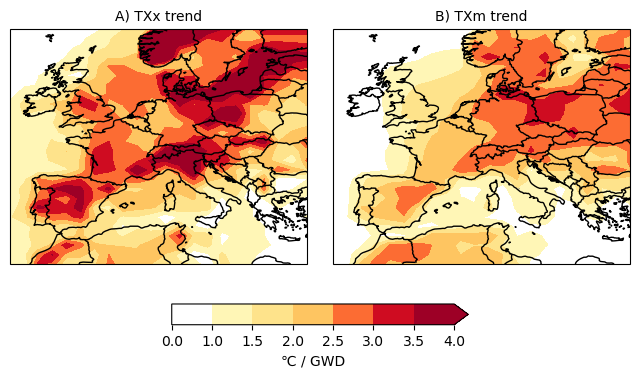

In [103]:
fig = plt.figure(figsize = (8,4))
gs = GridSpec(2, 4, figure=fig, height_ratios=[1, 0.08], width_ratios=[1, 1,1,1])

levels1 = np.array([0,1,1.5,2,2.5,3,3.5,4])
custom_colors1 = ["#ffffff","#ffffff","#fff6b6","#fee38b","#fec561","#fc6c33","#cf0c21","#9d0026"]
cmap1 = mcolors.ListedColormap(custom_colors1)

ax1 = fig.add_subplot(gs[0, 0:2],projection=ccrs.PlateCarree())
contour1 = ax1.contourf(lon_total_box, lat_total_box, total_Txx_b, cmap = cmap1, transform = ccrs.PlateCarree(), levels = levels1,extend = "max") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax1.coastlines()
ax1.add_feature(cf.BORDERS)
ax1.set_title("A) TXx trend",fontsize = 10)

ax2 = fig.add_subplot(gs[0, 2:],projection=ccrs.PlateCarree())
contour2 = ax2.contourf(lon_total_box, lat_total_box, total_Txm_b, cmap = cmap1, transform = ccrs.PlateCarree(), levels = levels1,extend = "max") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax2.coastlines()
ax2.add_feature(cf.BORDERS)
ax2.set_title("B) TXm trend",fontsize = 10)

cax1 = fig.add_subplot(gs[1,1:3])
plt.colorbar(contour1, cax=cax1, orientation="horizontal", label="\N{DEGREE CELSIUS} / GWD")
#plt.savefig("/usr/people/noest/stage_folders/outputs/figures_net/era5_total_trend_2014.png",dpi=300)
plt.show()
plt.close()


In [7]:
# plot_variable_normal(lat_total_box,lon_total_box,total_Txx_b,"test")

## **2014 dynamical trend (ERA5 and models combined)**

In [105]:
#Select which region to plot
Sv = 32
Nv = 63
Wv = -13
Ev = 28

In [106]:
#Load data for dynamical trend era5
os.chdir("/usr/people/noest/stage_folders/outputs/net/serious_run2/dynamical_trend/era5_prepared_psi")
dynamical_Txx = np.load("MAM_era5_TXx_slope_regridded_data_until_2014.npy")
dynamical_Txm = np.load("MAM_era5_TXm_slope_regridded_data_until_2014.npy")
dynamical_lat = np.load("MAM_era5_lat_extracted_regridded_data_until_2014.npy")
dynamical_lon = np.load("MAM_era5_lon_extracted_regridded_data_until_2014.npy")
dynamical_Txx_se = np.load("MAM_era5_TXx_stderr_regridded_data_until_2014.npy")
dynamical_Txm_se = np.load("MAM_era5_TXm_stderr_regridded_data_until_2014.npy")

with open("MAM_era5_meanTxxlist_regridded_data_until_2014.pkl", 'rb') as file:  # Open in binary mode for pickled files
    dynamical_Txx_trend = pickle.load(file)
with open("MAM_era5_meanTxmlist_regridded_data_until_2014.pkl", 'rb') as file:  # Open in binary mode for pickled files
    dynamical_Txm_trend = pickle.load(file)

In [107]:
dynamical_Txx_mask = significance_standard_deviation(dynamical_Txx,dynamical_Txx_se)
dynamical_Txm_mask = significance_standard_deviation(dynamical_Txm,dynamical_Txm_se)

In [108]:
#Extract area for dynamical
lat_dynamical_box,lon_dynamical_box,dynamical_Txx_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txx,event = True)
_,_,dynamical_Txm_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txm,event = True)
_,_,dynamical_Txx_mask_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txx_mask,event = True)
_,_,dynamical_Txm_mask_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,dynamical_Txm_mask,event = True)

In [109]:
#Squeeze everyting for dynamical
dynamical_Txx_b = np.squeeze(dynamical_Txx_b)
dynamical_Txm_b = np.squeeze(dynamical_Txm_b)
dynamical_Txx_mask_b = np.squeeze(dynamical_Txx_mask_b)
dynamical_Txm_mask_b = np.squeeze(dynamical_Txm_mask_b)

In [110]:
#HadGEM
os.chdir("/usr/people/noest/stage_folders/outputs/net/serious_run2/dynamical_trend/model_HadGem")
Hdynamical_Txx = np.load("MAM_TXx_all_ensembles.npy")
Hdynamical_Txm = np.load("MAM_TXm_all_ensembles.npy")
Hdynamical_Txx_se = np.load("MAM_stderr_stderr_txx.npy")
Hdynamical_Txm_se = np.load("MAM_stderr_stderr_txm.npy")

with open("MAM_model_meanTxxlist.pkl", 'rb') as file:  # Open in binary mode for pickled files
    Hdynamical_Txx_trend = pickle.load(file)
with open("MAM_model_meanTxmlist.pkl", 'rb') as file:  # Open in binary mode for pickled files
    Hdynamical_Txm_trend = pickle.load(file)

In [111]:
lat_dynamical_box,lon_dynamical_box,Hdynamical_Txx_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,Hdynamical_Txx,event = False)
_,_,Hdynamical_Txm_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,Hdynamical_Txm,event = False)
_,_,Hdynamical_Txx_se_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,Hdynamical_Txx_se,event = False)
_,_,Hdynamical_Txm_se_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,Hdynamical_Txm_se,event = False)

In [112]:
print (Hdynamical_Txm.shape,Hdynamical_Txx_se.shape)

(5, 33, 33) (5, 33, 33)


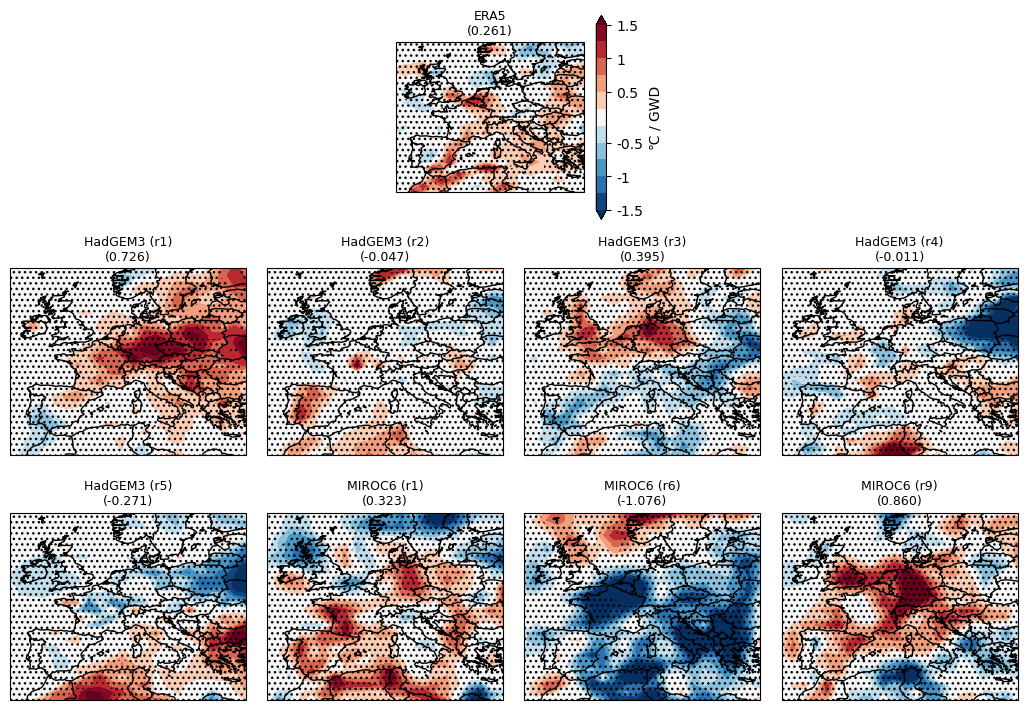

In [113]:
fig = plt.figure(figsize = (13,9))
gs = GridSpec(3, 8, figure=fig, height_ratios=[1, 1,1], width_ratios=[1, 1,1,1,1,1,1,1])
levels2 = np.array([-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25])
levels2 = np.array([-1.5,-1.25,-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1,1.25,1.5])

custom_colors2 = ["#ffffff","#fee38b","#fec561","#fd9f44","#fc6c33","#ef3323","#cf0c21","#9d0026"]
custom_cmap2 = mcolors.ListedColormap(custom_colors2)
custom_cmap2 = "RdBu_r"

t1 = 0
t2 = 2


ax = fig.add_subplot(gs[0, 3:5],projection=ccrs.PlateCarree())
contour1 = ax.contourf(lon_dynamical_box, lat_dynamical_box, dynamical_Txx_b, cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = levels2,extend = "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax.contourf(lon_dynamical_box, lat_dynamical_box,dynamical_Txx_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '...'], colors='none', transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.set_title(f"ERA5\n({dynamical_Txx_trend[0]:.3f})",loc="center",fontsize = 9)
cbar1 = plt.colorbar(contour1, ax=ax, orientation = "vertical", label = "\N{DEGREE CELSIUS} / GWD", pad = 0.05)
cbar1.set_ticks([-1.5,-1,-0.5,0.5,1,1.5])
cbar1.set_ticklabels([-1.5,-1,-0.5,0.5,1,1.5])
for i in range(4):
    ax = fig.add_subplot(gs[1, t1:t2],projection=ccrs.PlateCarree())
    contour1 = ax.contourf(lon_dynamical_box, lat_dynamical_box, Hdynamical_Txx_b[i], cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = levels2,extend = "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
    mask = significance_standard_deviation(Hdynamical_Txx_b[i],Hdynamical_Txx_se_b[i])
    ax.contourf(lon_dynamical_box, lat_dynamical_box,mask, levels=[-0.5,0.5,1.5], hatches=[None, '...'], colors='none', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    ax.set_title(f"HadGEM3 (r{i+1})\n({Hdynamical_Txx_trend[i]:.3f})",loc="center",fontsize = 9)
    t1 = t1 + 2
    t2 = t2 + 2

i = 4
ax = fig.add_subplot(gs[2, 0:2],projection=ccrs.PlateCarree())
contour1 = ax.contourf(lon_dynamical_box, lat_dynamical_box, Hdynamical_Txx_b[i], cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = levels2,extend = "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
mask = significance_standard_deviation(Hdynamical_Txx_b[i],Hdynamical_Txx_se_b[i])
ax.contourf(lon_dynamical_box, lat_dynamical_box,mask, levels=[-0.5,0.5,1.5], hatches=[None, '...'], colors='none', transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.set_title(f"HadGEM3 (r{i+1})\n({Hdynamical_Txx_trend[i]:.3f})",loc="center",fontsize = 9)

en = [1,6,9]
os.chdir("/usr/people/noest/stage_folders/outputs/net/serious_run2/dynamical_trend/model_MIROC")

t1 = 2
t2 = 4

for i in range(3):
    txx =  np.load(f"MAM_r{en[i]}_miroc_TXx_slope_regridded_data_until_2014.npy")
    std = np.load(f"MAM_r{en[i]}_miroc_TXx_stderr_regridded_data_until_2014.npy")
    with open(f"MAM_r{en[i]}_miroc_meanTxxlist_regridded_data_until_2014.pkl", 'rb') as file:  # Open in binary mode for pickled files
        trend = pickle.load(file)
    mask = significance_standard_deviation(txx,std)
    _,_,txx_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,txx,event = True)
    _,_,mask_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,mask,event = True)
    txx_b = np.squeeze(txx_b)
    mask_b = np.squeeze(mask_b)

    ax = fig.add_subplot(gs[2, t1:t2],projection=ccrs.PlateCarree())
    contour1 = ax.contourf(lon_dynamical_box, lat_dynamical_box, txx_b, cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = levels2,extend = "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
    ax.contourf(lon_dynamical_box, lat_dynamical_box,mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '...'], colors='none', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    ax.set_title(f"MIROC6 (r{en[i]})\n({trend[0]:.3f})",loc="center",fontsize = 9)
    t1 = t1 + 2
    t2 = t2 + 2
#plt.savefig("/usr/people/noest/stage_folders/outputs/figures_net/model_dynamic_TXx_cmap.png",dpi=600)
plt.show()

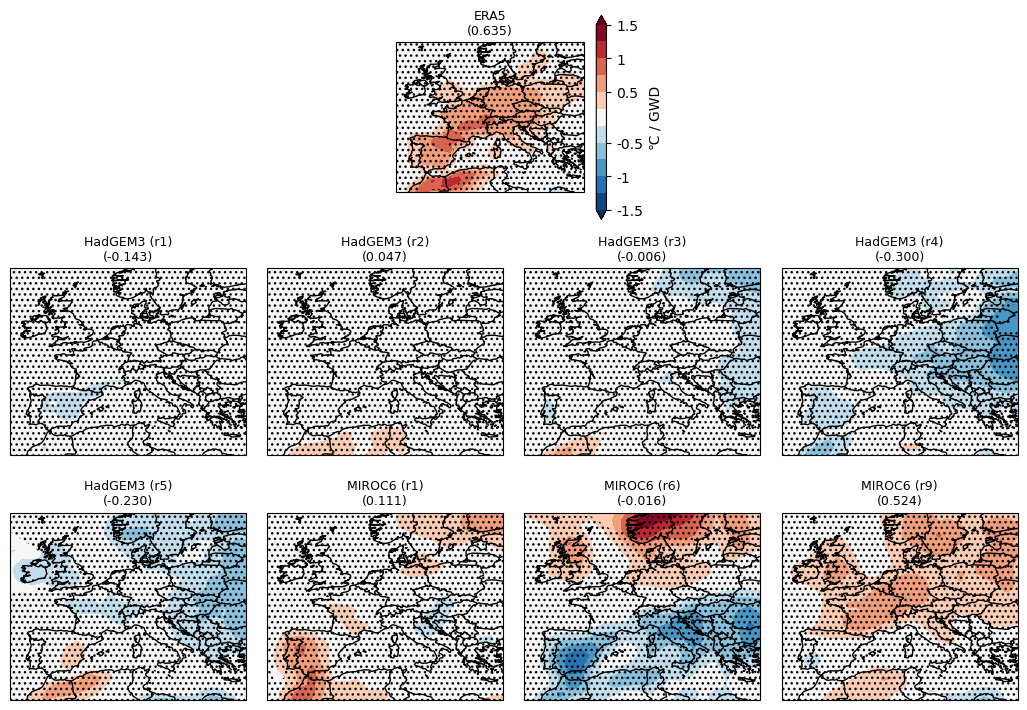

In [114]:
fig = plt.figure(figsize = (13,9))
gs = GridSpec(3, 8, figure=fig, height_ratios=[1, 1,1], width_ratios=[1, 1,1,1,1,1,1,1])
levels2 = np.array([-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25])
levels2 = np.array([-1.5,-1.25,-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1,1.25,1.5])

custom_colors2 = ["#ffffff","#fee38b","#fec561","#fd9f44","#fc6c33","#ef3323","#cf0c21","#9d0026"]
custom_cmap2 = mcolors.ListedColormap(custom_colors2)
custom_cmap2 = "RdBu_r"

t1 = 0
t2 = 2


ax = fig.add_subplot(gs[0, 3:5],projection=ccrs.PlateCarree())
contour1 = ax.contourf(lon_dynamical_box, lat_dynamical_box, dynamical_Txm_b, cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = levels2,extend = "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax.contourf(lon_dynamical_box, lat_dynamical_box,dynamical_Txm_mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '...'], colors='none', transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.set_title(f"ERA5\n({dynamical_Txm_trend[0]:.3f})",loc="center",fontsize = 9)
cbar1 = plt.colorbar(contour1, ax=ax, orientation = "vertical", label = "\N{DEGREE CELSIUS} / GWD", pad = 0.05)
cbar1.set_ticks([-1.5,-1,-0.5,0.5,1,1.5])
cbar1.set_ticklabels([-1.5,-1,-0.5,0.5,1,1.5])
for i in range(4):
    ax = fig.add_subplot(gs[1, t1:t2],projection=ccrs.PlateCarree())
    contour1 = ax.contourf(lon_dynamical_box, lat_dynamical_box, Hdynamical_Txm_b[i], cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = levels2,extend = "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
    mask = significance_standard_deviation(Hdynamical_Txm_b[i],Hdynamical_Txm_se_b[i])
    ax.contourf(lon_dynamical_box, lat_dynamical_box,mask, levels=[-0.5,0.5,1.5], hatches=[None, '...'], colors='none', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    ax.set_title(f"HadGEM3 (r{i+1})\n({Hdynamical_Txm_trend[i]:.3f})",loc="center",fontsize = 9)
    t1 = t1 + 2
    t2 = t2 + 2

i = 4
ax = fig.add_subplot(gs[2, 0:2],projection=ccrs.PlateCarree())
contour1 = ax.contourf(lon_dynamical_box, lat_dynamical_box, Hdynamical_Txm_b[i], cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = levels2,extend = "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
mask = significance_standard_deviation(Hdynamical_Txm_b[i],Hdynamical_Txm_se_b[i])
ax.contourf(lon_dynamical_box, lat_dynamical_box,mask, levels=[-0.5,0.5,1.5], hatches=[None, '...'], colors='none', transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.set_title(f"HadGEM3 (r{i+1})\n({Hdynamical_Txm_trend[i]:.3f})",loc="center",fontsize = 9)

en = [1,6,9]
os.chdir("/usr/people/noest/stage_folders/outputs/net/serious_run2/dynamical_trend/model_MIROC")

t1 = 2
t2 = 4

for i in range(3):
    txm =  np.load(f"MAM_r{en[i]}_miroc_TXm_slope_regridded_data_until_2014.npy")
    std = np.load(f"MAM_r{en[i]}_miroc_TXm_stderr_regridded_data_until_2014.npy")
    with open(f"MAM_r{en[i]}_miroc_meanTxmlist_regridded_data_until_2014.pkl", 'rb') as file:  # Open in binary mode for pickled files
        trend = pickle.load(file)
    mask = significance_standard_deviation(txm,std)
    _,_,txm_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,txm,event = True)
    _,_,mask_b = extract_area(Sv,Nv,Wv,Ev,dynamical_lat,dynamical_lon,mask,event = True)
    txm_b = np.squeeze(txm_b)
    mask_b = np.squeeze(mask_b)

    ax = fig.add_subplot(gs[2, t1:t2],projection=ccrs.PlateCarree())
    contour1 = ax.contourf(lon_dynamical_box, lat_dynamical_box, txm_b, cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = levels2,extend = "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
    ax.contourf(lon_dynamical_box, lat_dynamical_box,mask_b, levels=[-0.5,0.5,1.5], hatches=[None, '...'], colors='none', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    ax.set_title(f"MIROC6 (r{en[i]})\n({trend[0]:.3f})",loc="center",fontsize = 9)
    t1 = t1 + 2
    t2 = t2 + 2
#plt.savefig("/usr/people/noest/stage_folders/outputs/figures_net/model_dynamic_TXm_cmap.png",dpi=600)
plt.show()